# 2022-09-13 Bernstein Conference

## Creating input

In [12]:
from brainhack import make_input_aer, plot_input, cospattern, linear, vonmises
import numpy as np
import matplotlib.pyplot as plt
import random

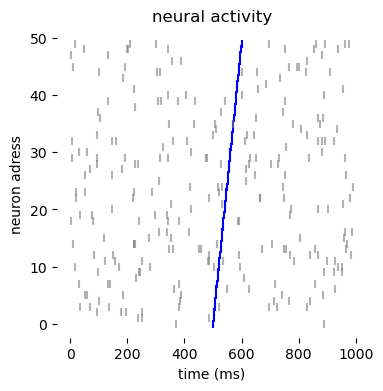

In [2]:
nb_synapses, noise_density, simulation_time, t_true = 50, 5e-3, 1e3, .5e3
pattern_temporal_amplitude = 100
pattern = linear

aer_noise, aer_pattern, aer_both = make_input_aer(nb_synapses, noise_density, simulation_time, pattern_temporal_amplitude, t_true, function=pattern)
fig, ax = plot_input(aer_noise, aer_pattern)

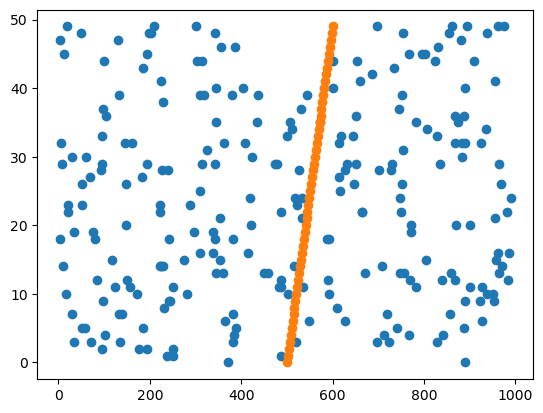

In [4]:
plt.scatter(aer_noise[1],aer_noise[0])
plt.scatter(aer_pattern[1], aer_pattern[0])

In [5]:
len(aer_noise[1])

250

## A leaky Integrate and fire neurons implemented in an event-based fashion

In [2]:
from brainhack import hsd_neuron, plot_hsd_response

$V(t) = V_{rest} + \gamma \cdot (V_\theta-V_{rest}) \cdot \sum_{s} \omega_s \sum_{r \in \epsilon_{pre}} K_s(t, t_r) - \sum_{f \in \epsilon_{post}} (V_\theta-V_{rest}) \cdot e^{-\frac{t - t_f}{\tau}}$

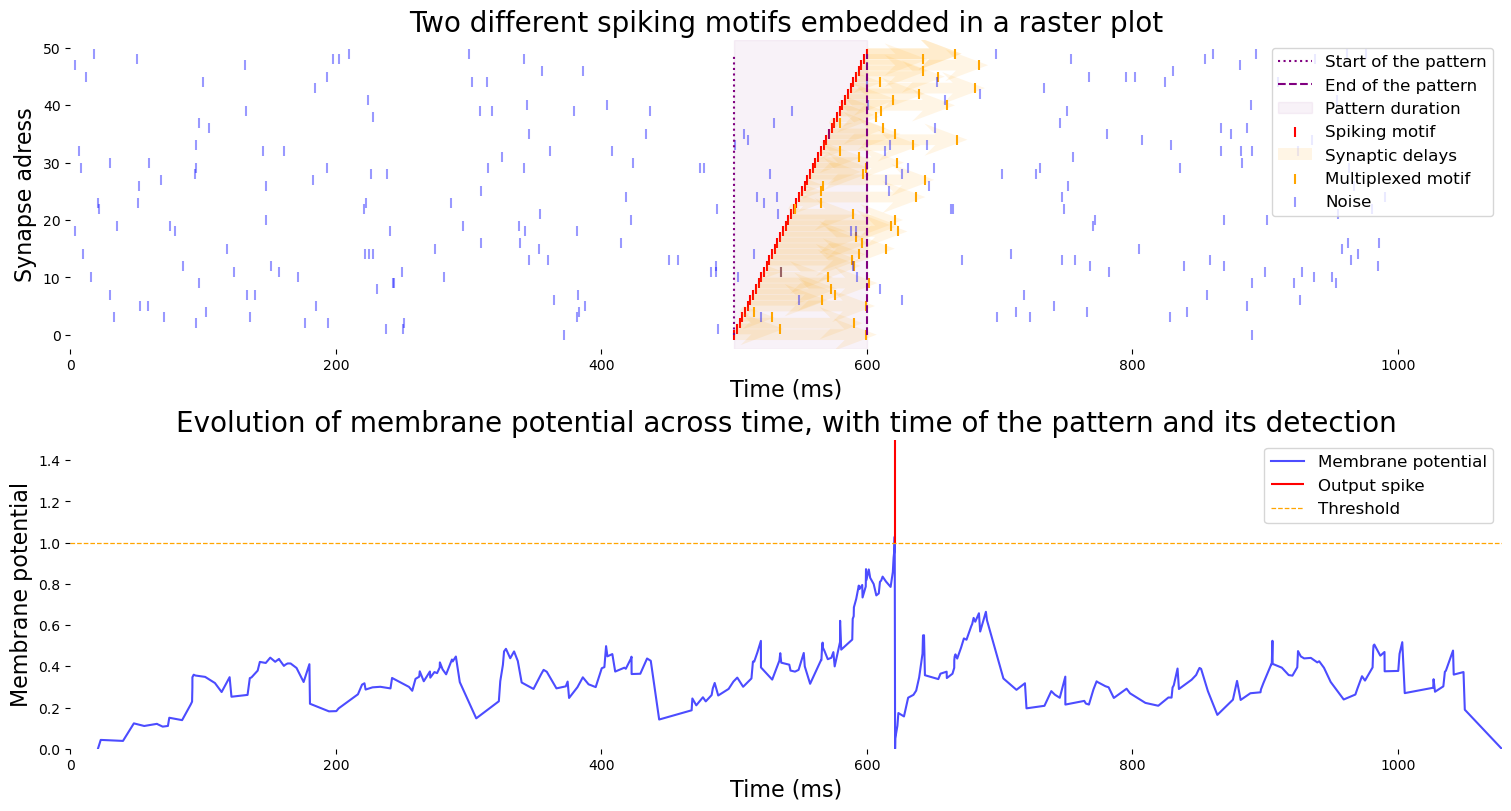

In [7]:
gain = 3
tau = 20
delay_amplitude = pattern_temporal_amplitude

N = hsd_neuron(nb_synapses, tau = tau, gain = gain, delay_amplitude = delay_amplitude)

V, sorted_times, sorted_addresses, t_out = N.code(aer_both)

fig_neuron, axs_neuron = plot_hsd_response(sorted_times, sorted_addresses, V, N, t_true, t_out, delay_amplitude, aer_noise, aer_pattern)

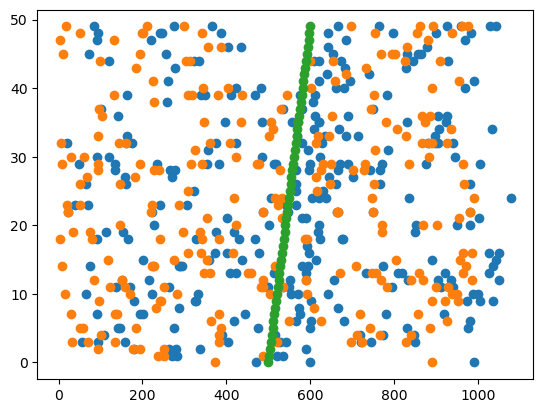

In [8]:
plt.figure()
plt.scatter(sorted_times,sorted_addresses)
plt.scatter(aer_noise[1],aer_noise[0])
plt.scatter(aer_pattern[1], aer_pattern[0])

### Change of the time constant of the neuron

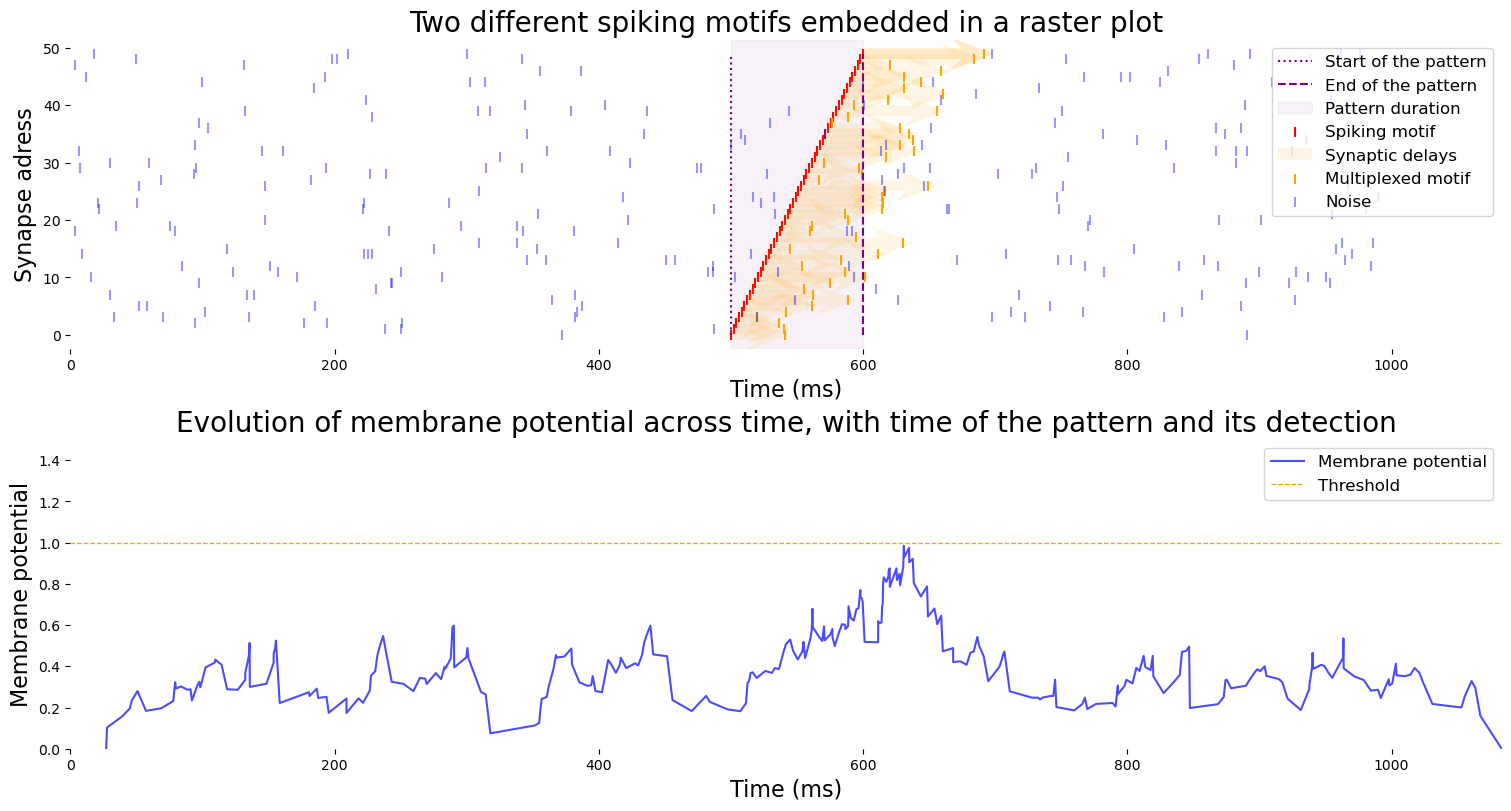

In [9]:
gain = 3
tau = 20
delay_amplitude = pattern_temporal_amplitude

N = hsd_neuron(nb_synapses, tau = tau, gain = gain, delay_amplitude = delay_amplitude)

V, sorted_times, sorted_addresses, t_out = N.code(aer_both)

fig_neuron, axs_neuron = plot_hsd_response(sorted_times, sorted_addresses, V, N, t_true, t_out, delay_amplitude, aer_noise, aer_pattern)

[]

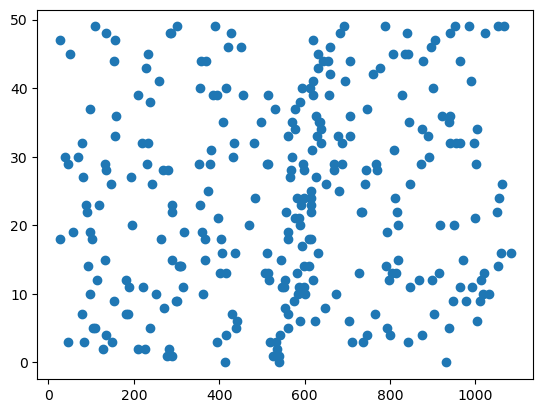

In [10]:
plt.figure()
plt.scatter(sorted_times,sorted_addresses)
[plt.axvline(k,color='firebrick') for k in t_out]

[]

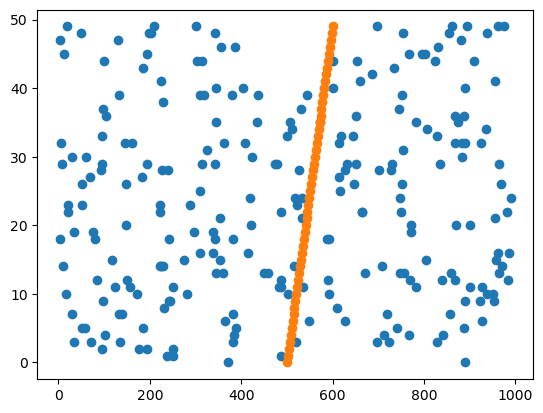

In [11]:
plt.figure()
plt.scatter(aer_noise[1],aer_noise[0])
plt.scatter(aer_pattern[1], aer_pattern[0])
[plt.axvline(k,color='firebrick') for k in t_out]

## Unsupervised learning of the delays obtained by derivating the membrane potential 

We compute the membrane potential (V) with a non-causal LIF kernel ($e^{-\frac{\left|t - t_r - \delta_s \right|}{\tau}}$) for the first computations. Then we will pass to causal kernel.

We can compute the gradient of V at the time of the output spike and adjust the delays to maximize V at the output spike time. 
We set an adjustment of the gain to keep the firing rate constant (prior knowledge). The neuron will spike one time during simulation time. 

In [4]:
from brainhack import plot_learning_figure, absolute_kernel, gaussian_kernel
import numpy as np
import time

tau = 101 gain = 1.01


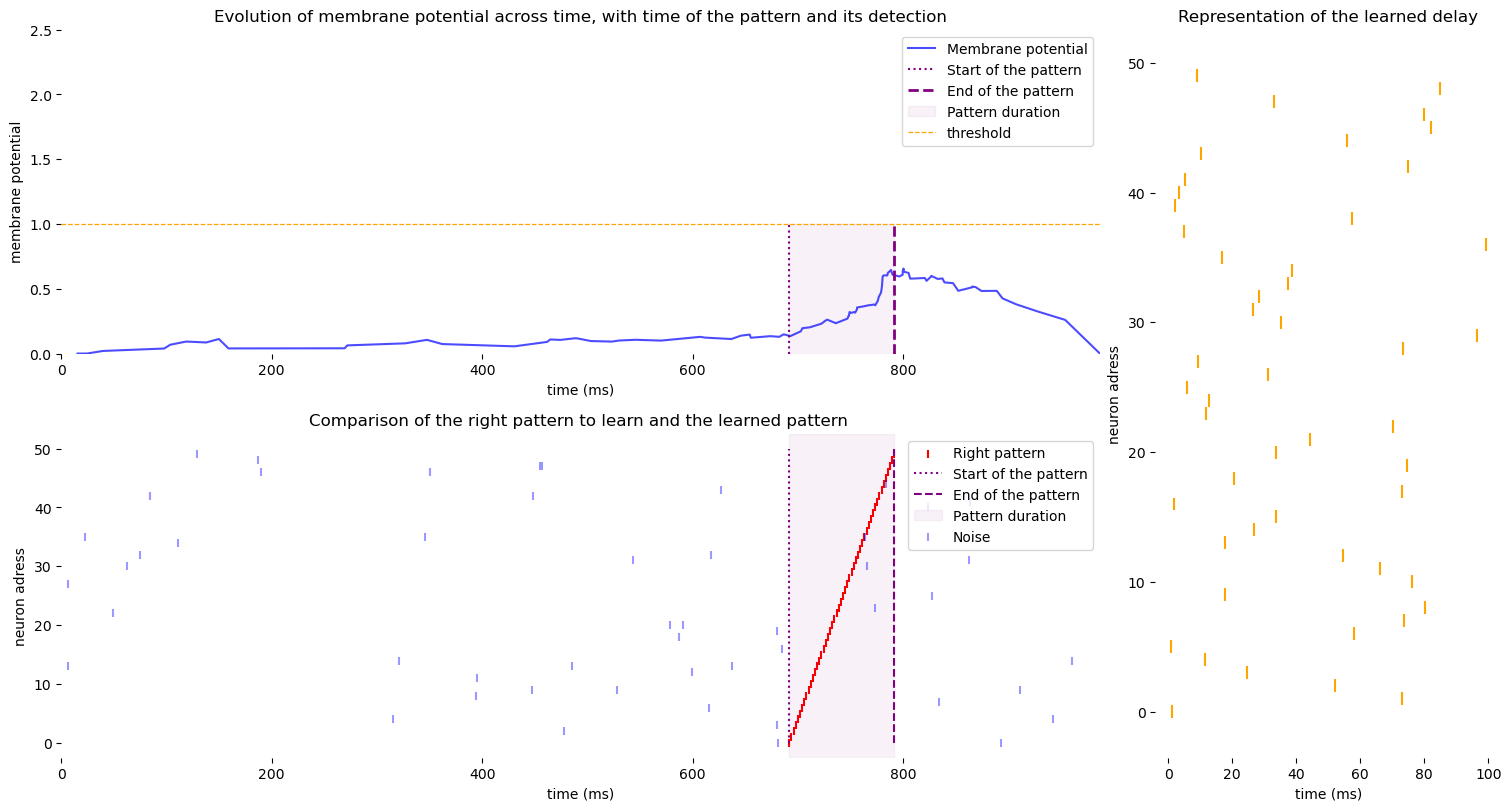

tau = 153 gain = 1.5300000000000005


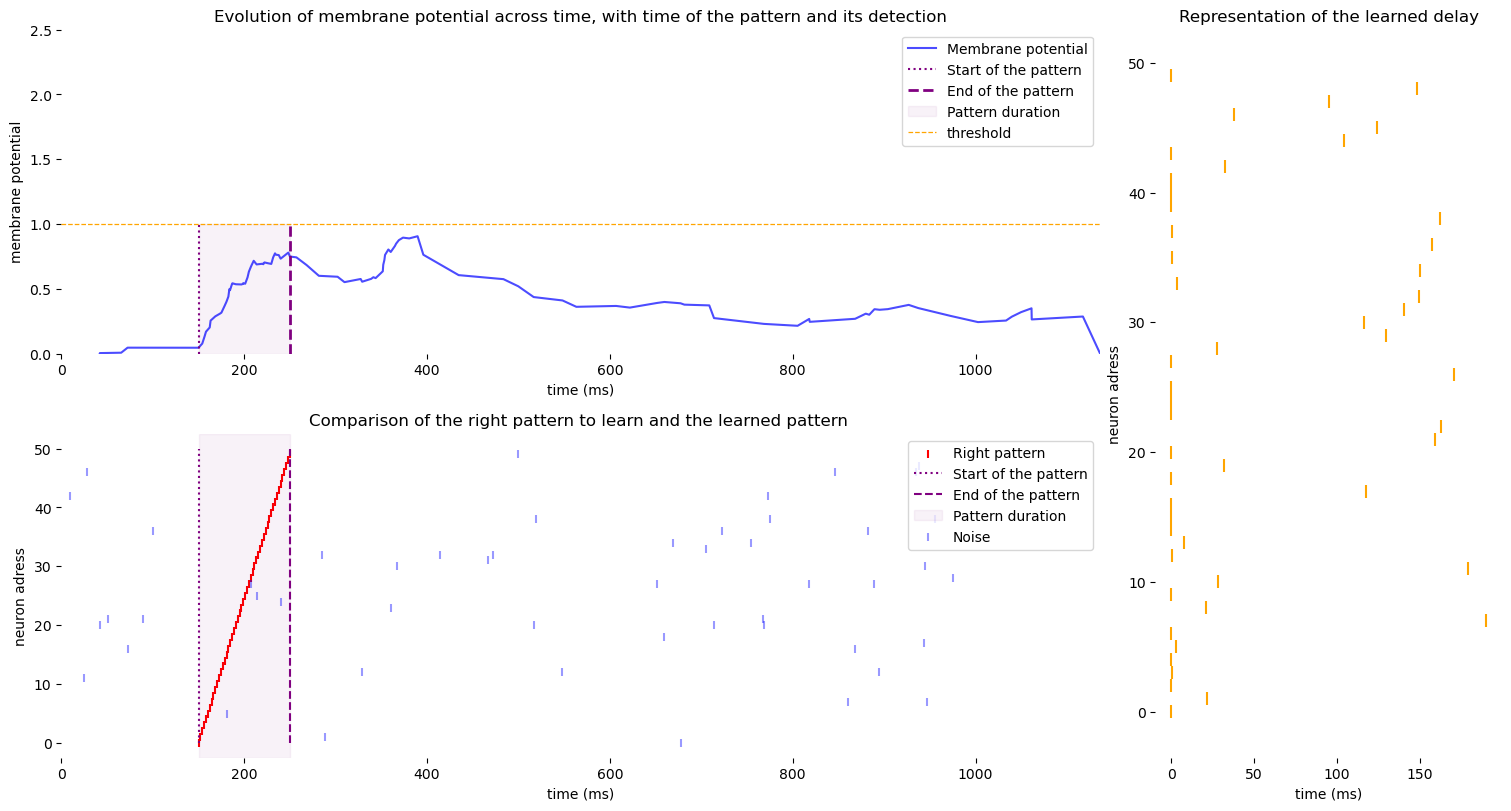

tau = 149 gain = 1.4900000000000004


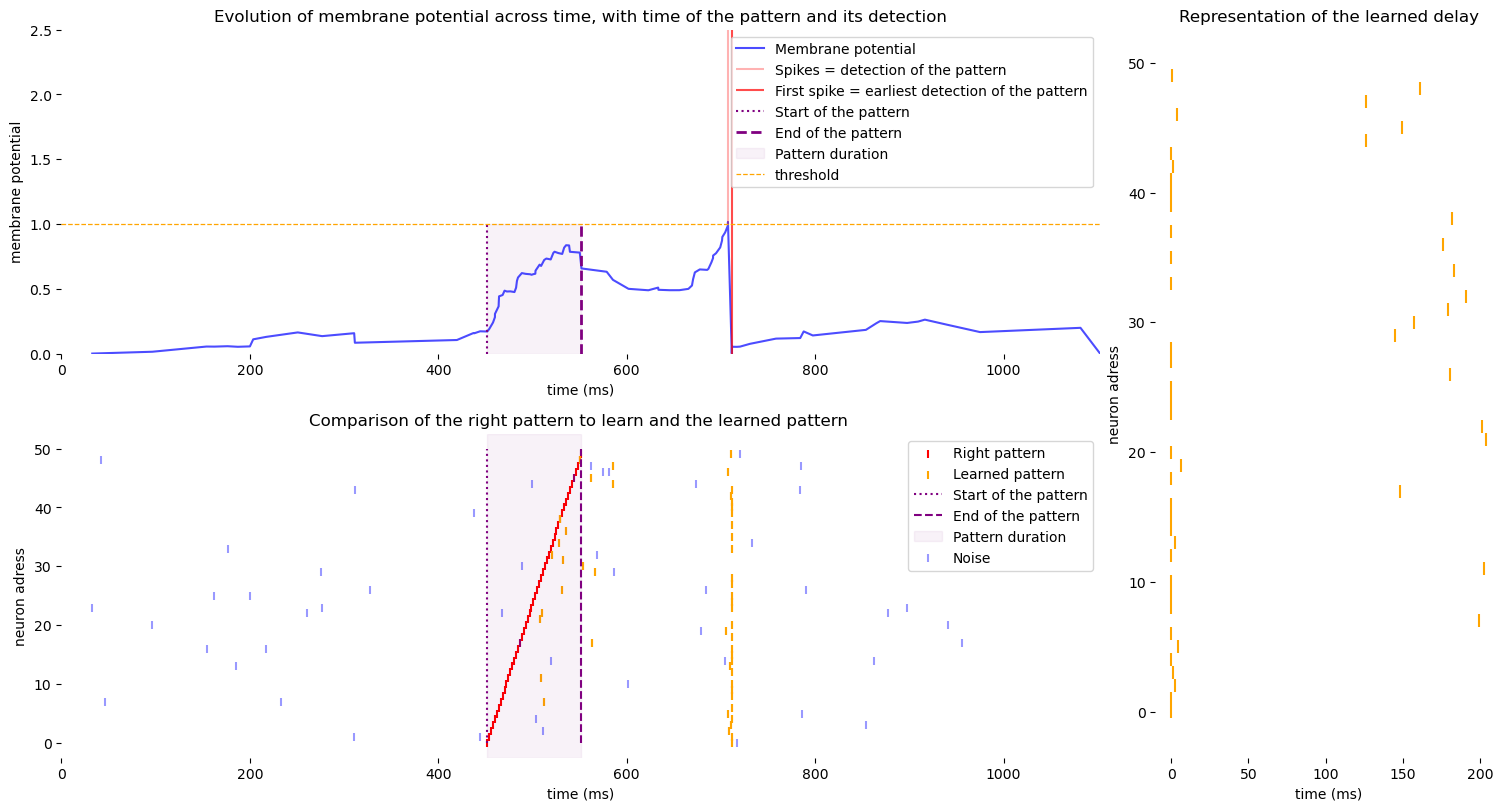

tau = 157 gain = 1.5700000000000005


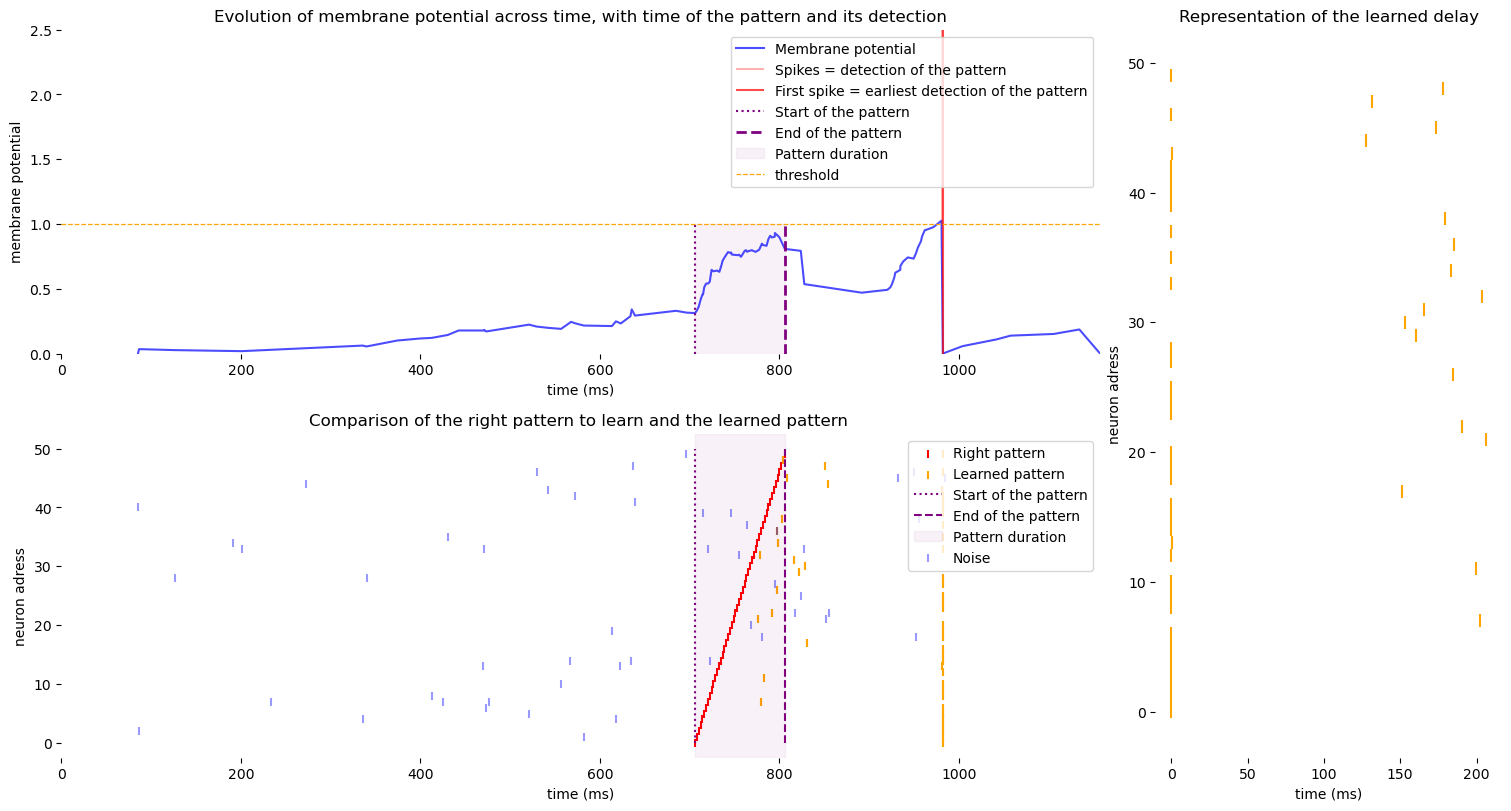

tau = 155 gain = 1.5500000000000005


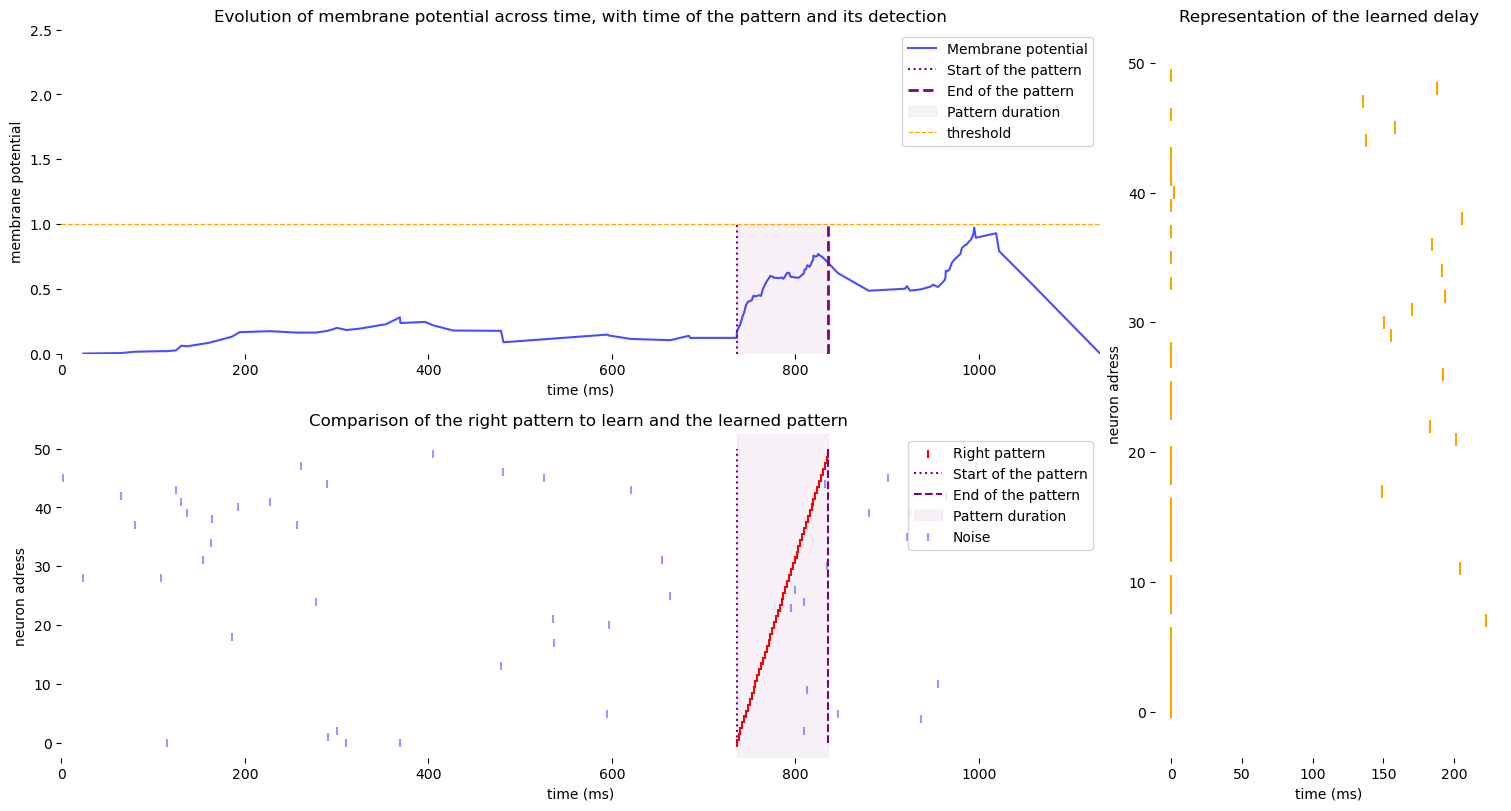

tau = 155 gain = 1.5500000000000005


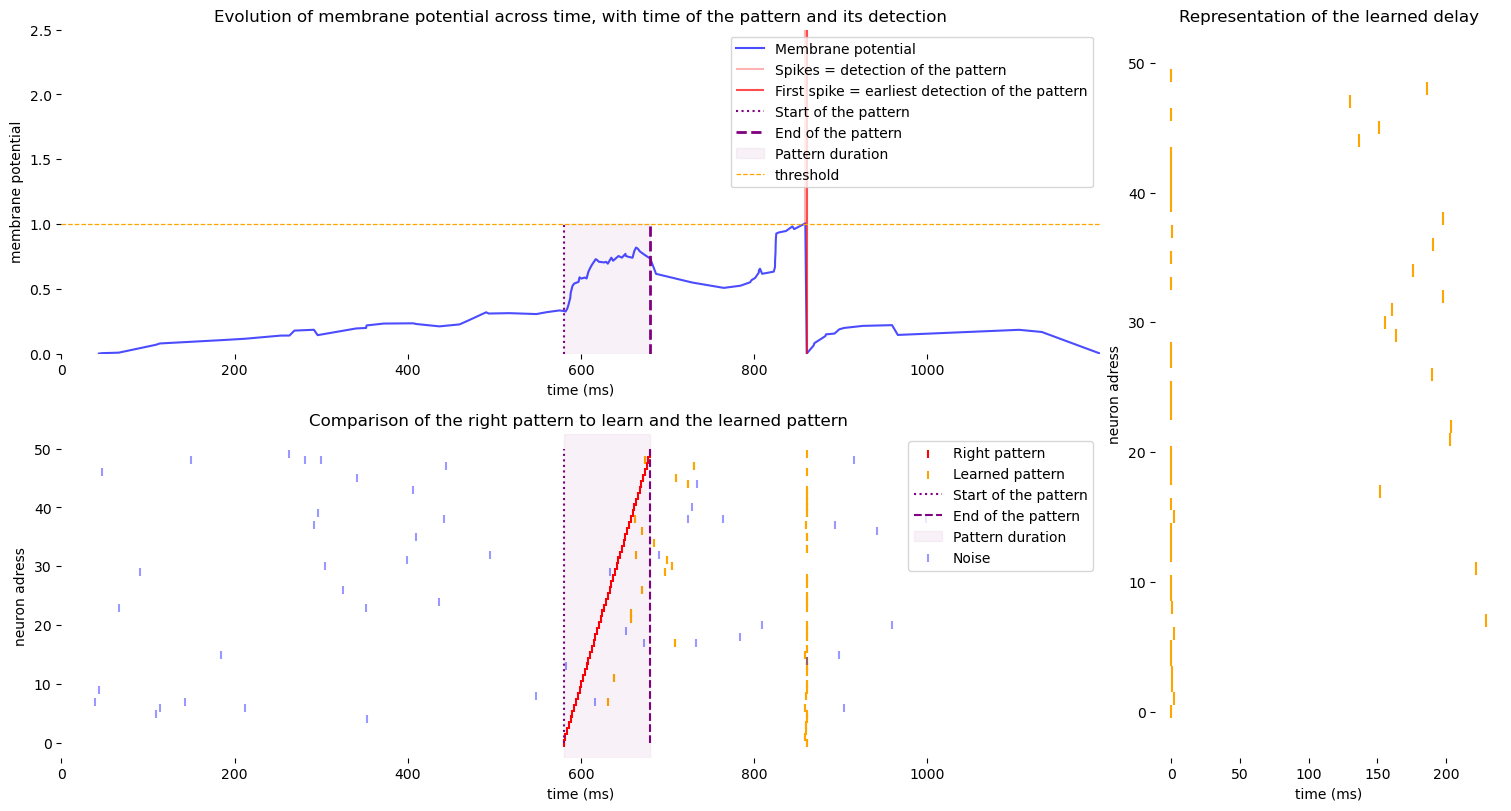

tau = 155 gain = 1.5500000000000005


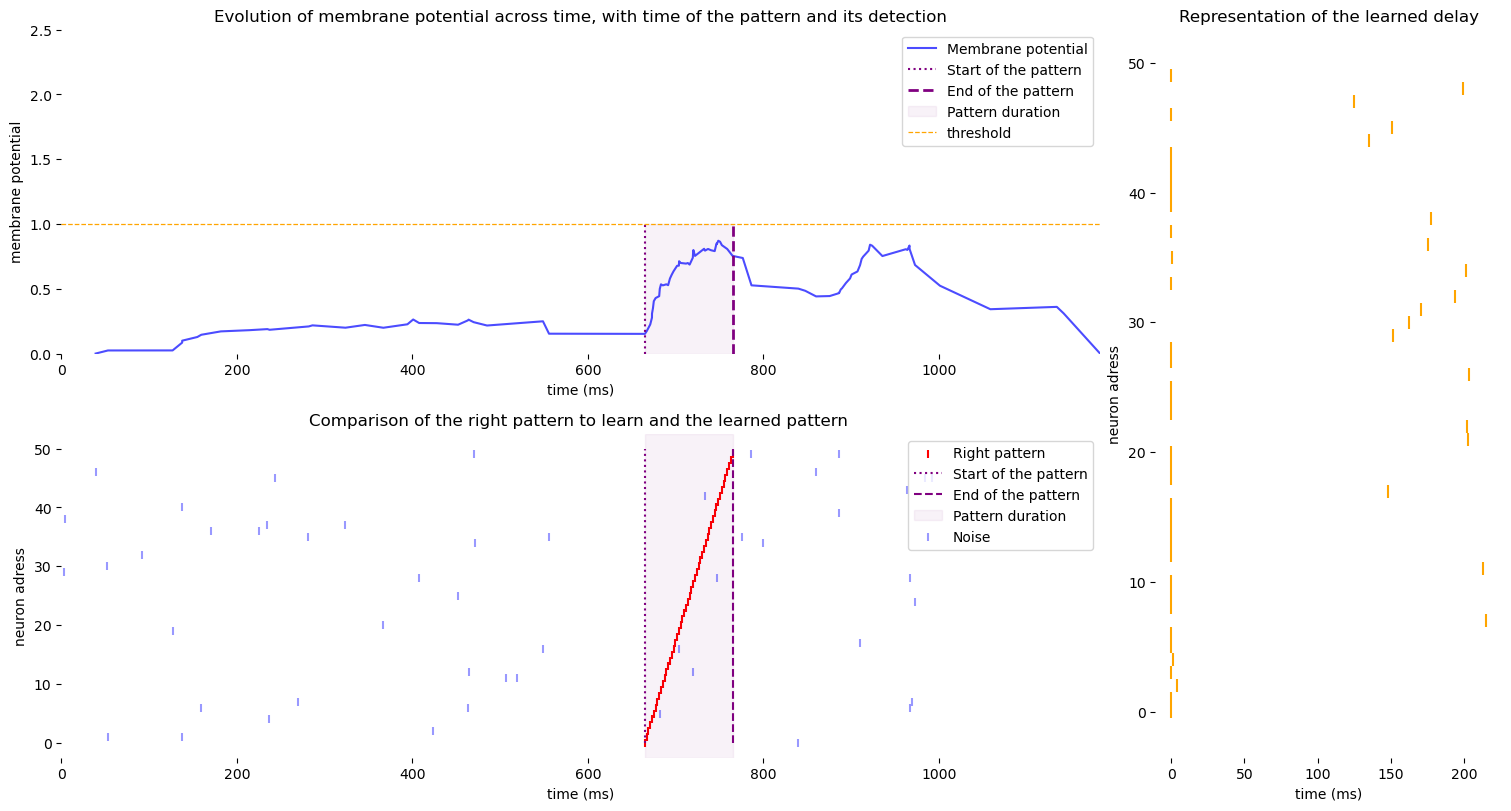

tau = 157 gain = 1.5700000000000005


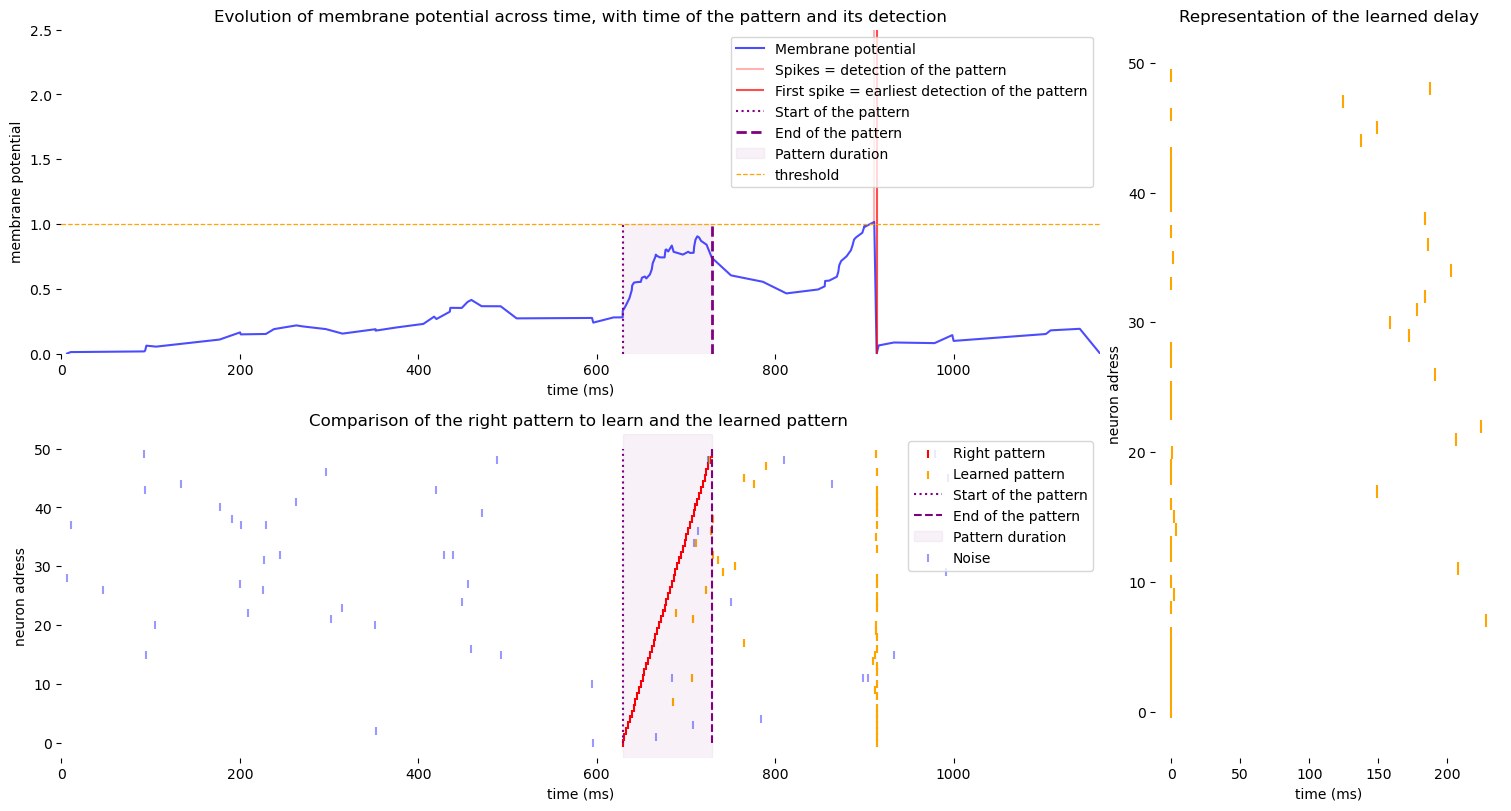

tau = 155 gain = 1.5500000000000005


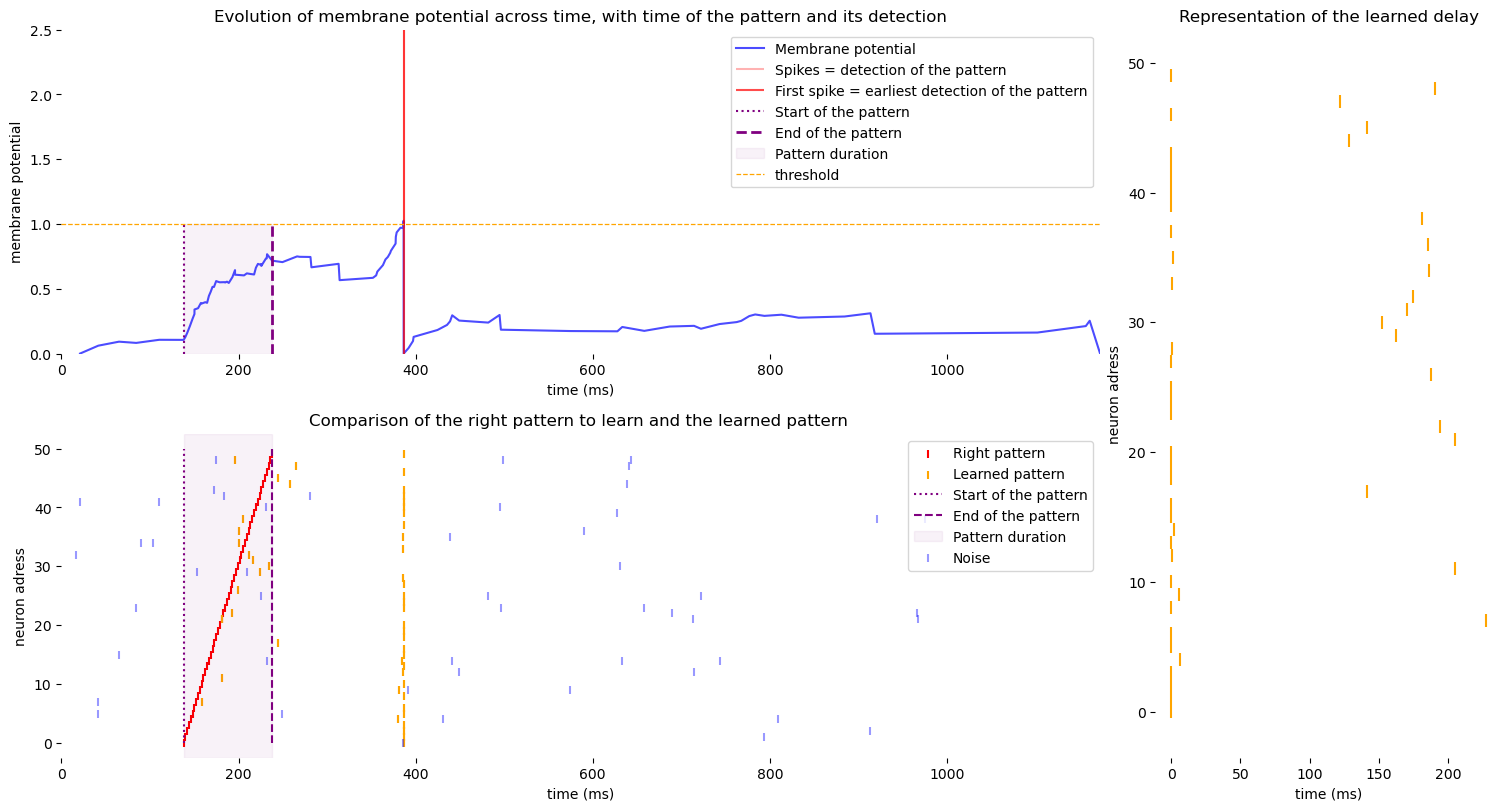

tau = 155 gain = 1.5500000000000005


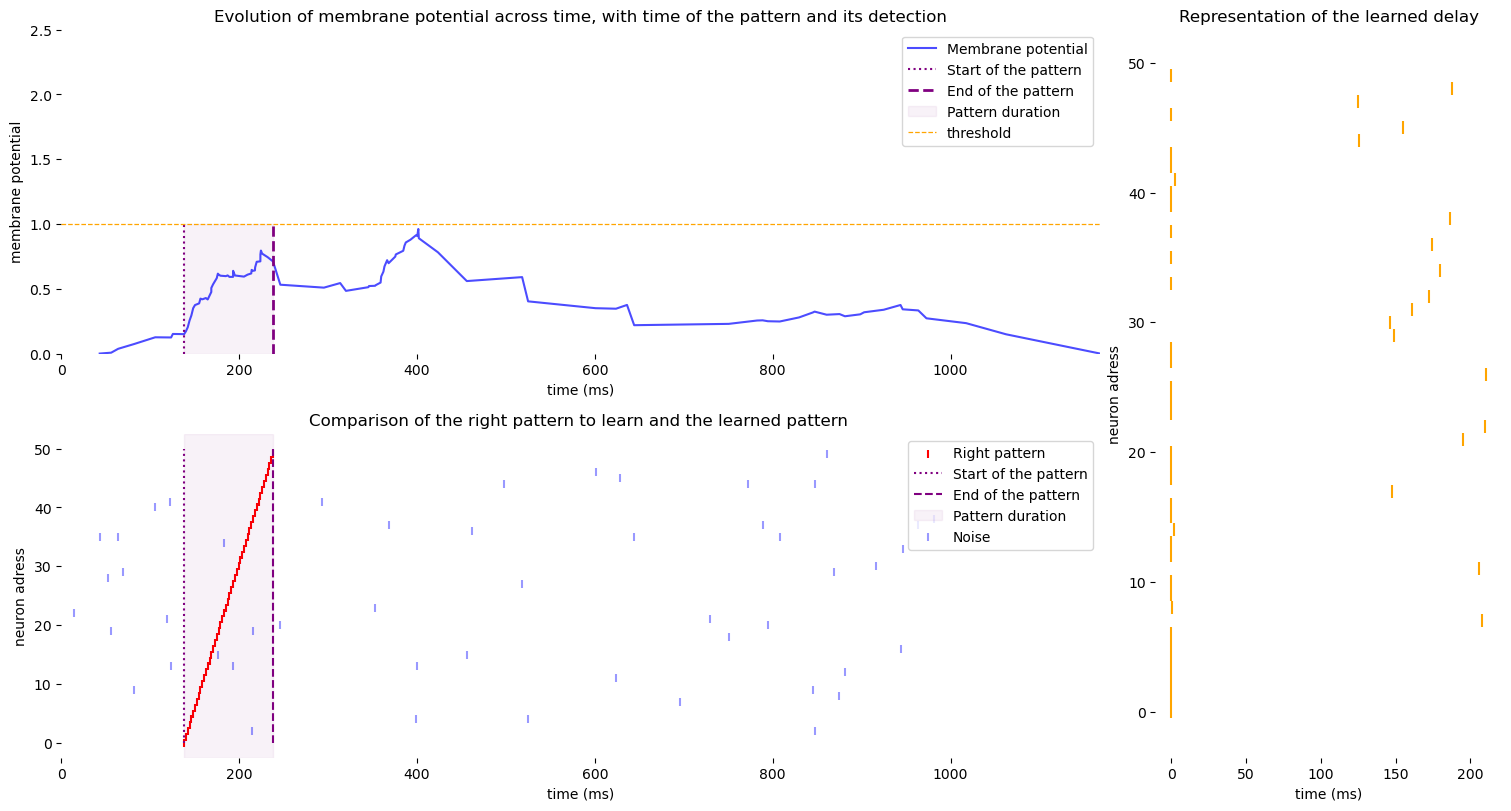

tau = 157 gain = 1.5700000000000005


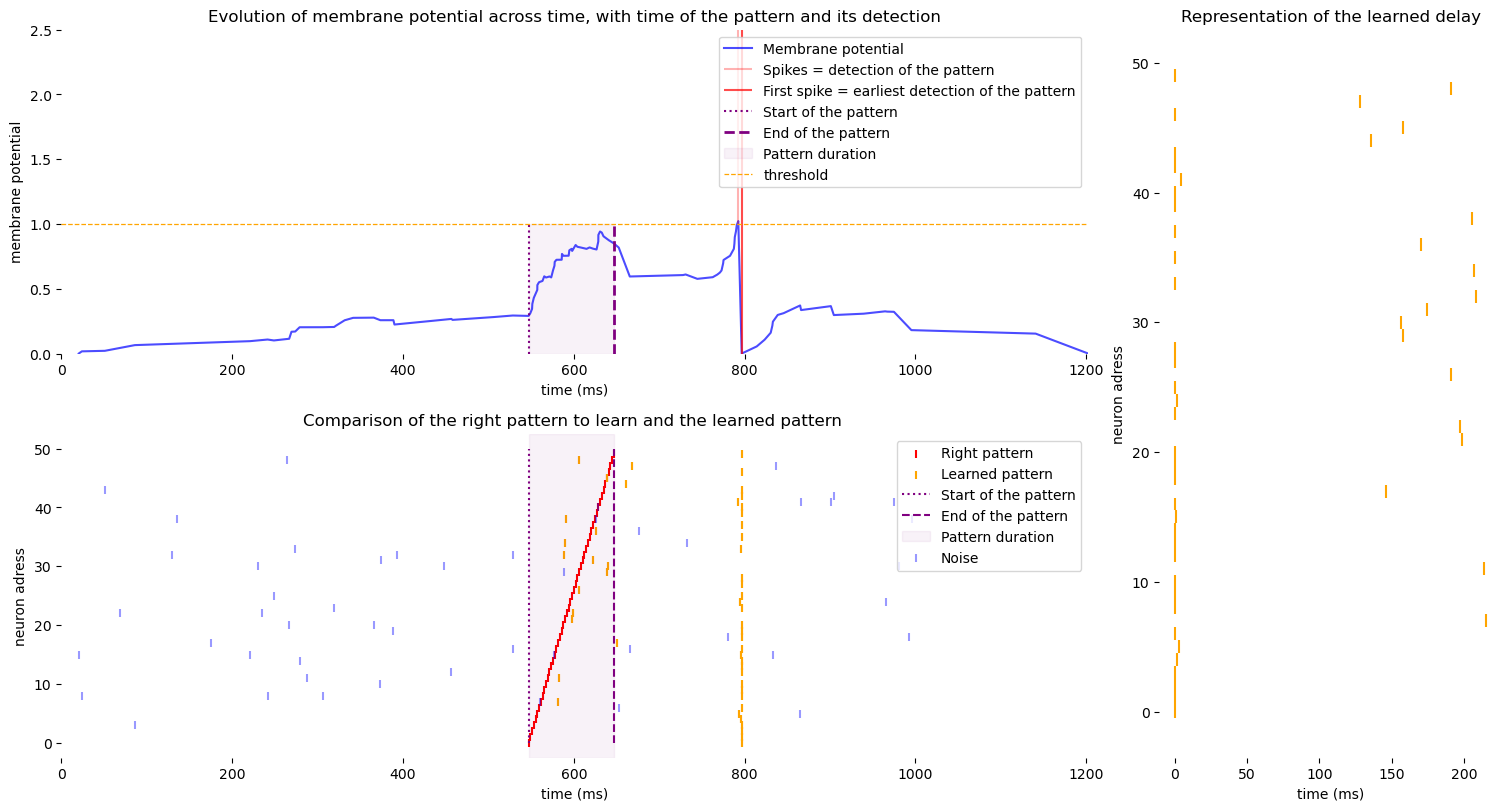

In [28]:
tau = delay_amplitude
gain = 1
pattern=linear

N = hsd_neuron(nb_synapses, tau = tau, gain = gain, delay_amplitude = delay_amplitude)

noise_density =  1e-3
learning_rate_tau = 1
learning_rate_gain = 0.01
learning_rate_delay = 100
N_epochs = 2001
lambda_delay = .0001
momentum = .3

delay_gradient_history = np.zeros((N_epochs, len(N.delays)))
delays_history = np.zeros((N_epochs, len(N.delays)))


for i_epoch in range(N_epochs):
    t_true = delay_amplitude + int(np.random.rand()*(simulation_time-3*delay_amplitude)) # so this is the true number of pattern appearences

    aer_noise, aer_pattern, aer = make_input_aer(nb_synapses, noise_density, simulation_time, delay_amplitude, t_true, function = pattern)
    V, sorted_times, sorted_addresses, t_out = N.code(aer)

    output_spikes_number = len(t_out) # number of times the pattern triggered a repsonse fro mthe Lif neuron
    expected_output_spikes = len([t_true])
    
    if output_spikes_number==0: # if no spikes were triggered than tau (inverse decay) scales by the learning rate
        N.tau += learning_rate_tau*expected_output_spikes
        N.gain += learning_rate_gain*expected_output_spikes
    else:
        for t_post in t_out:
            V_out = V[sorted_times==t_post]
            delay_gradient = delay_gradient_ = np.zeros([len(N.delays)])
            for add in range(len(N.delays)):
                spike_times = sorted_times[np.where(sorted_addresses==add)[0]]
                if len(spike_times)>0:
                    delta_delay = t_post-N.delays[add]-spike_times#[spike_times<t_post+delay_amplitude]
                    delay_function = N.weights[add]*np.sign(delta_delay)*absolute_kernel(delta_delay, N.tau)*N.gain
                    delay_gradient[add] = (delay_function).sum()
                    #print(delay_gradient)
                    delay_gradient[add] += lambda_delay*N.delays[add]
                
            delay_gradient_ = momentum * delay_gradient_ + (1-momentum)*delay_gradient
            N.delays -= learning_rate_delay*delay_gradient#*delay_amplitude
            N.delays[N.delays<0]=0
            #if np.linalg.norm(N.delays)!=0:
            #    N.delays *= delay_amplitude/np.linalg.norm(N.delays)
            
            delay_gradient_history[i_epoch] = delay_gradient
            delays_history[i_epoch] = N.delays
        
        N.tau += learning_rate_tau*(expected_output_spikes-(output_spikes_number+1))
        N.gain += learning_rate_gain*(expected_output_spikes-(output_spikes_number+1))
    if i_epoch % (N_epochs//10) == 0:
        print('tau = ' + str(N.tau), 'gain = ' + str(N.gain))
        plot_learning_figure(sorted_times, V, N, t_out, t_true, delay_amplitude, aer_noise, aer_pattern, delay_gradient=None)
    

### This is my attempt!!!

changing a few things, such as how delays are updated (following an stdp shape)
fixing tau and only updating the gain


In [2]:
from brainhack import *

In [3]:
nb_synapses, noise_density, simulation_time, t_true = 50, .5e-3, 1e3, np.array([0, 150, 200, 300])
pattern_temporal_amplitude = 100
pattern = linear
gain = 3
tau = 20
delay_amplitude = pattern_temporal_amplitude


spike_trains, (adress_pattern, time_pattern), aer = make_spiketrains_motif(nb_synapses, noise_density, simulation_time, pattern_temporal_amplitude, t_true, function=pattern)
# fig, ax = plot_input(time_pattern, aer_pattern)



tau = 20 gain = 3.01
epoch: 0


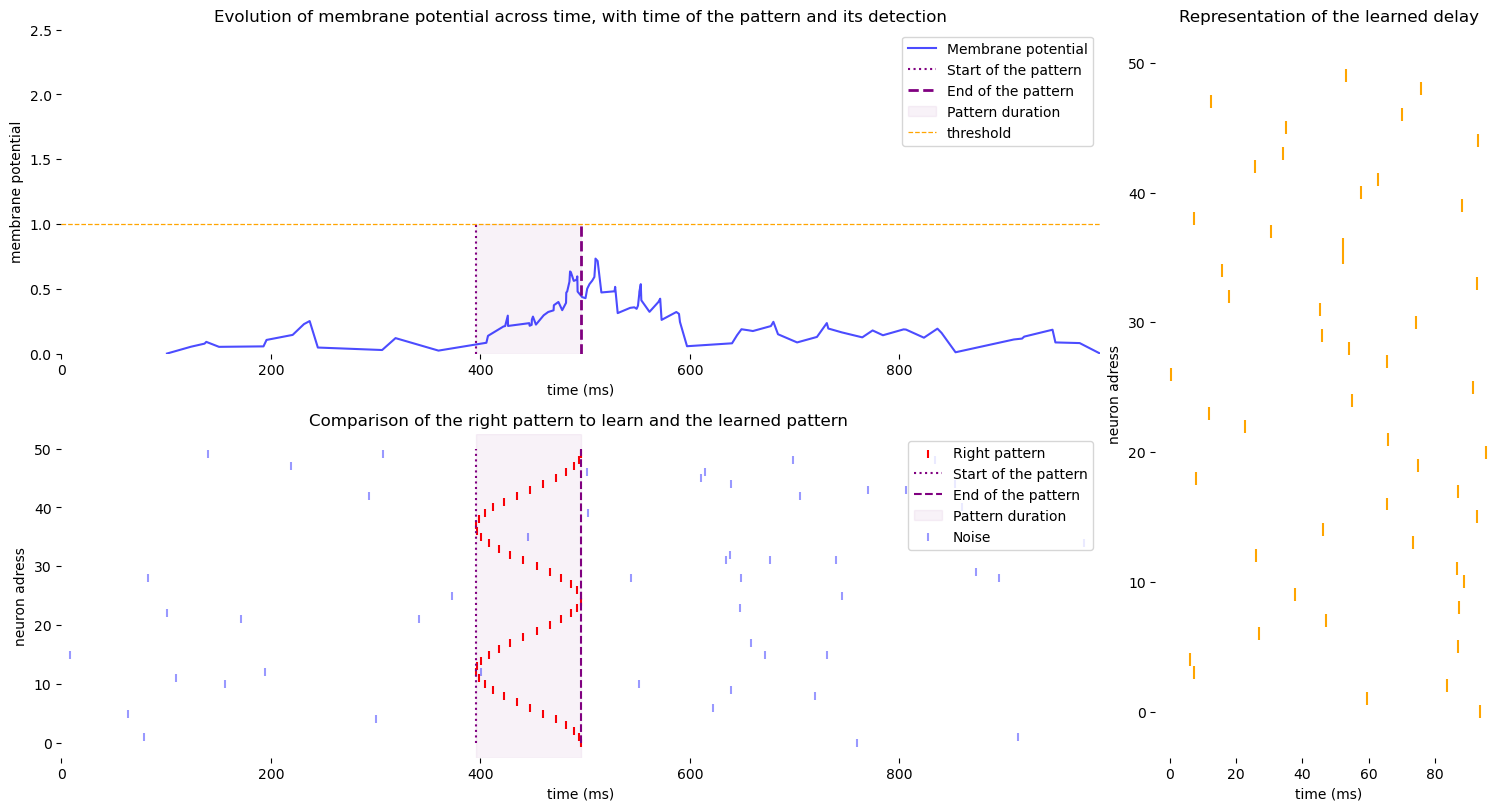

tau = 20 gain = 3.1099999999999977
epoch: 10


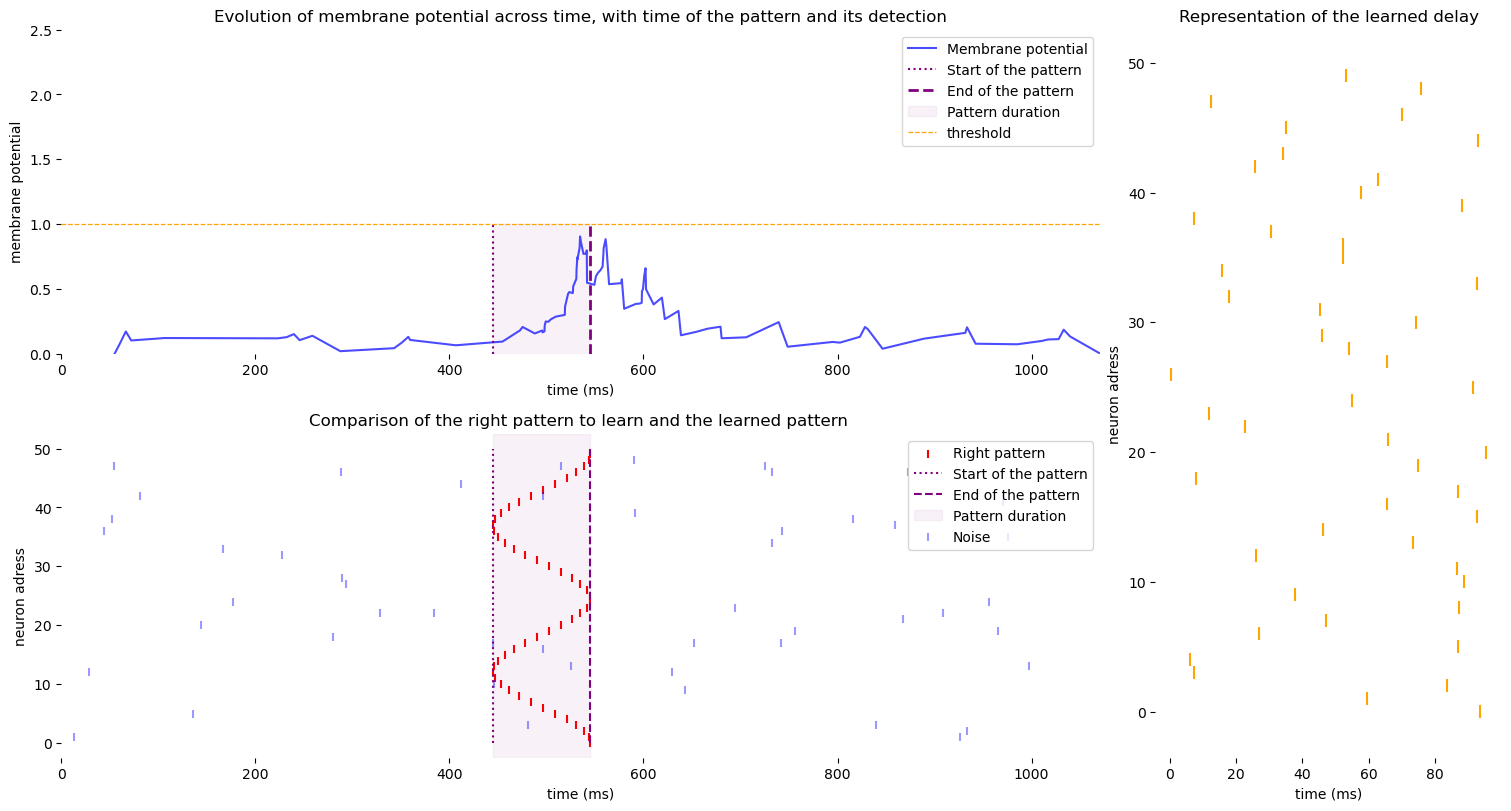

tau = 20 gain = 3.2099999999999955
epoch: 20


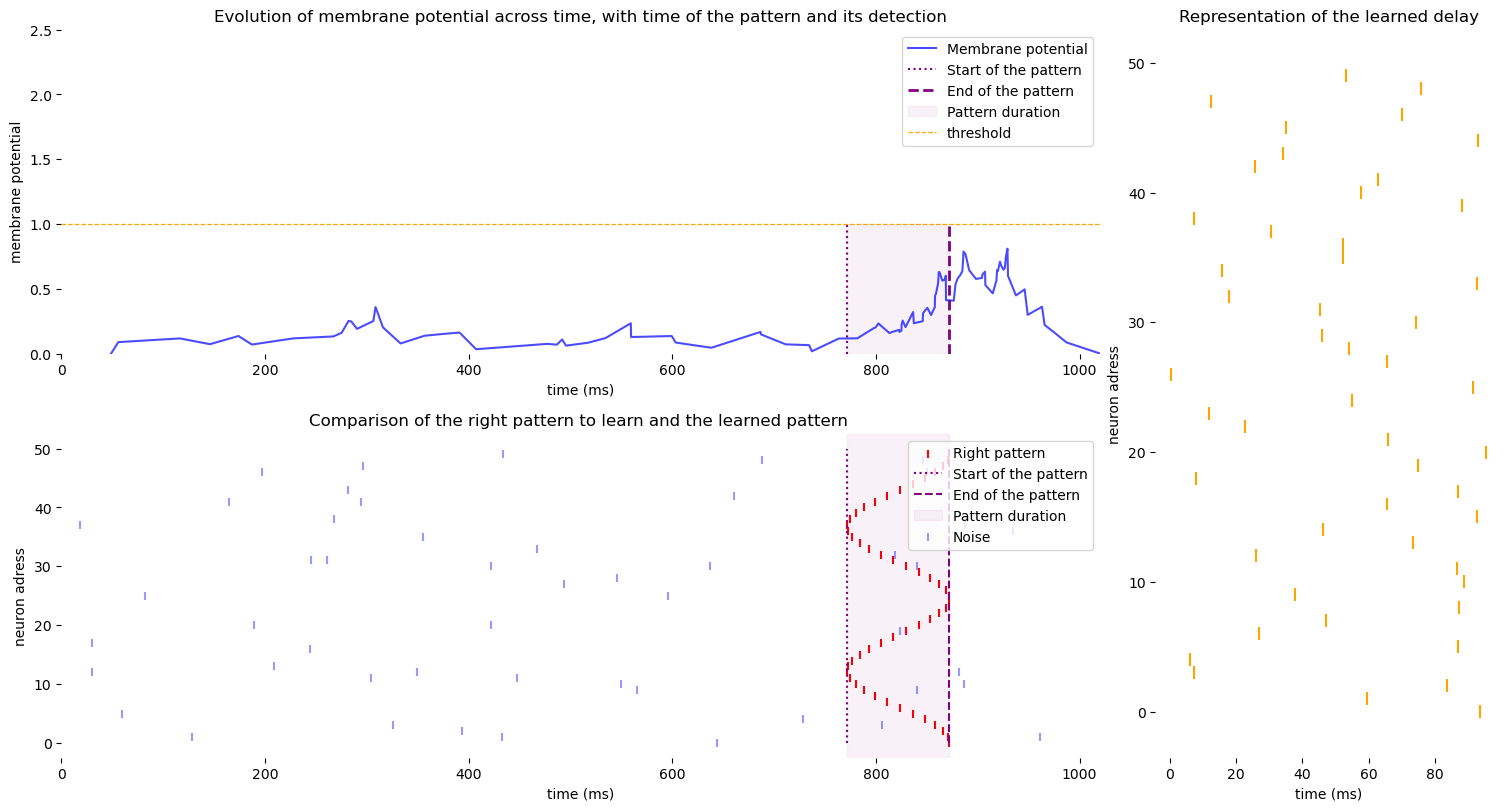

tau = 20 gain = 3.3099999999999934
epoch: 30


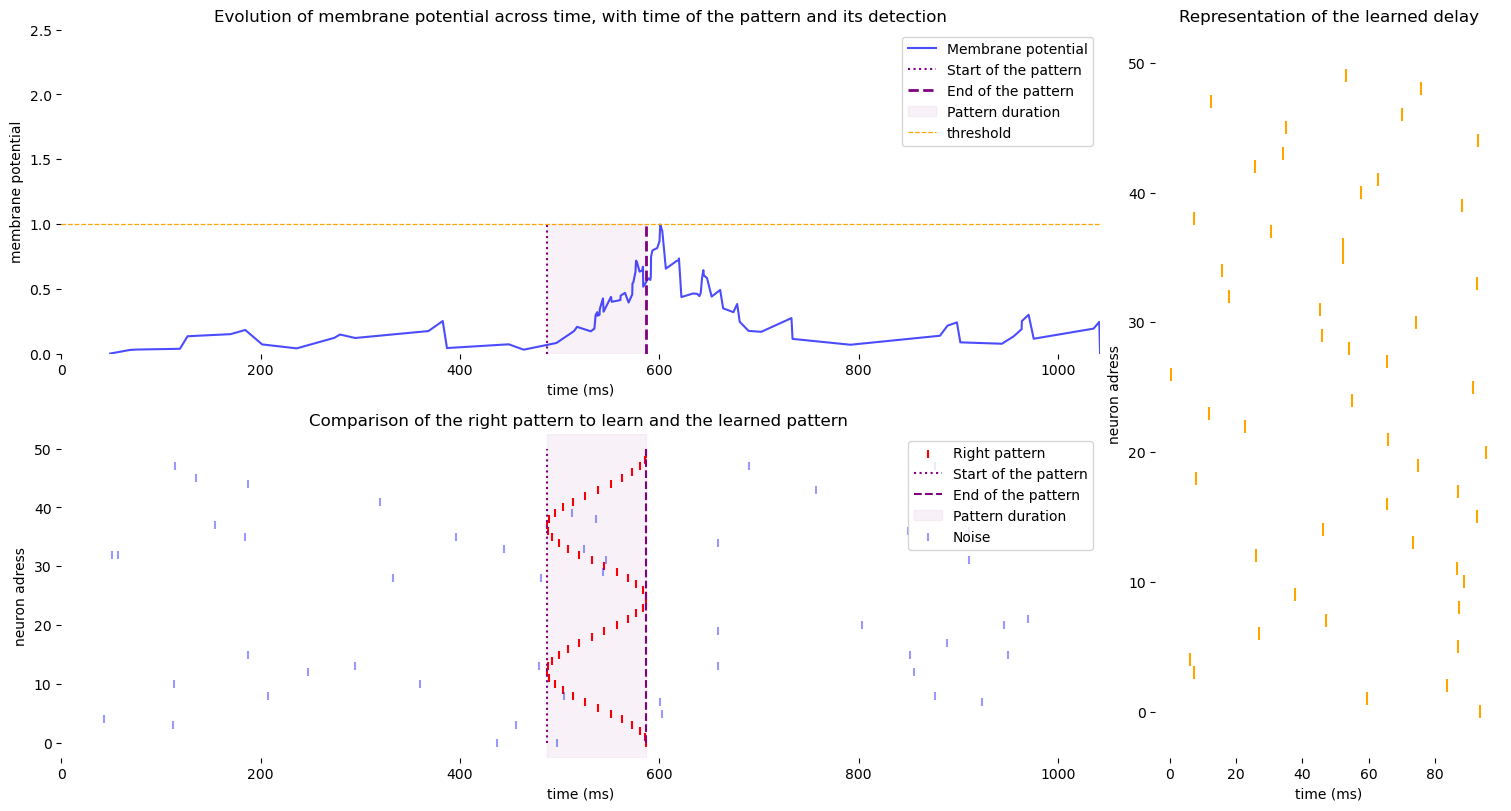

tau = 20 gain = 3.4099999999999913
epoch: 40


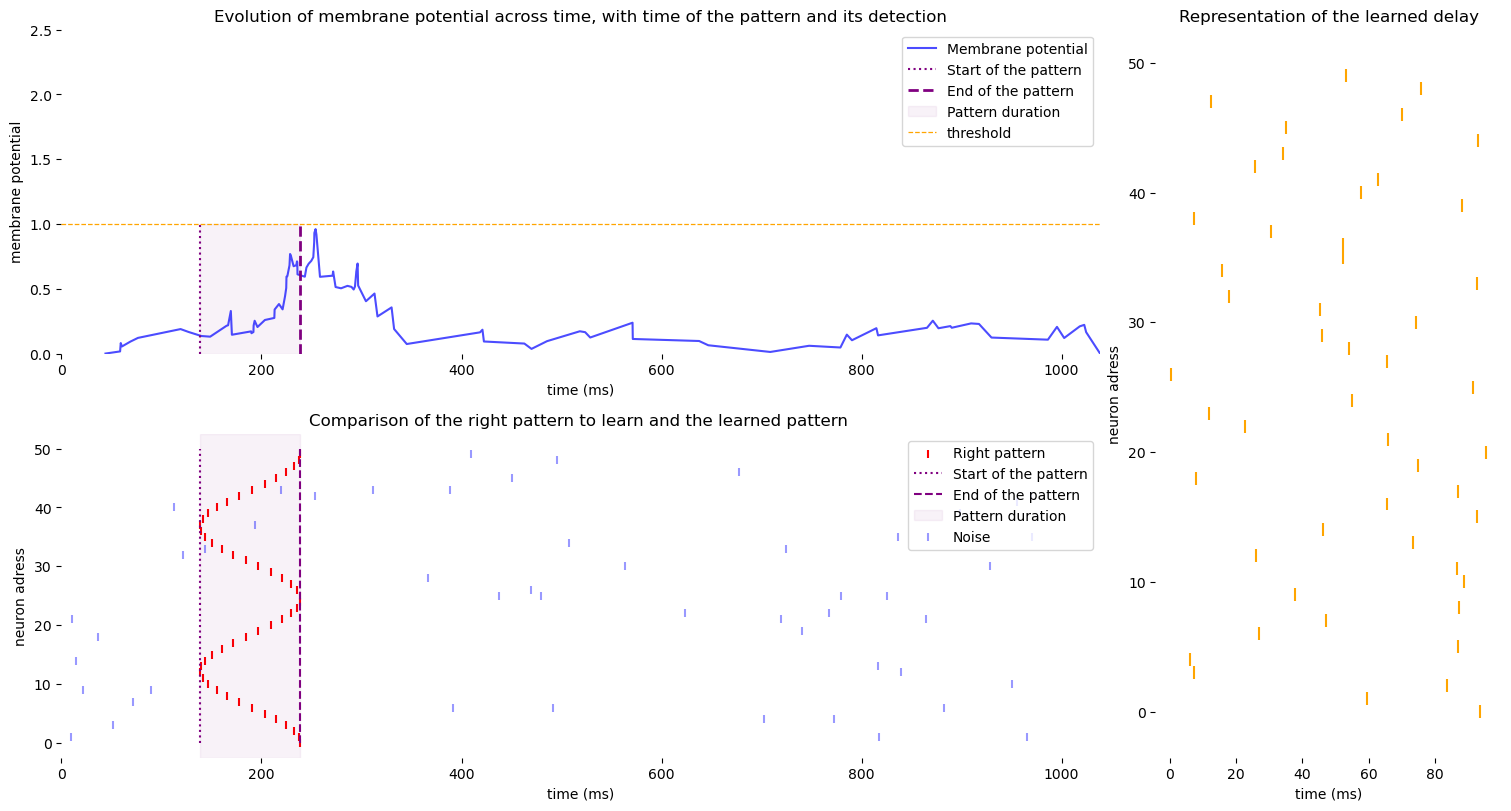

tau = 20 gain = 3.509999999999989
epoch: 50


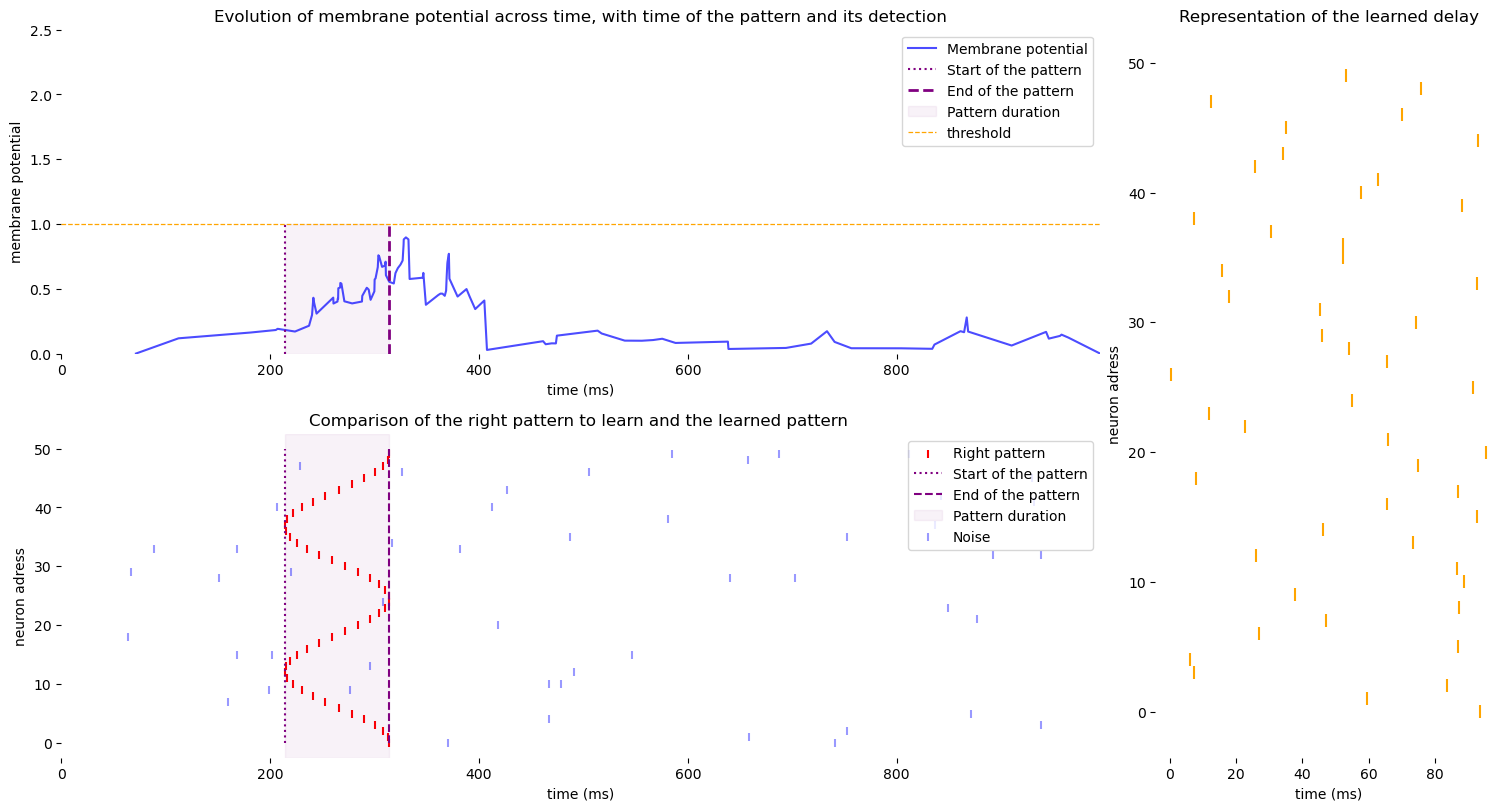

tau = 20 gain = 3.4199999999999906
epoch: 60


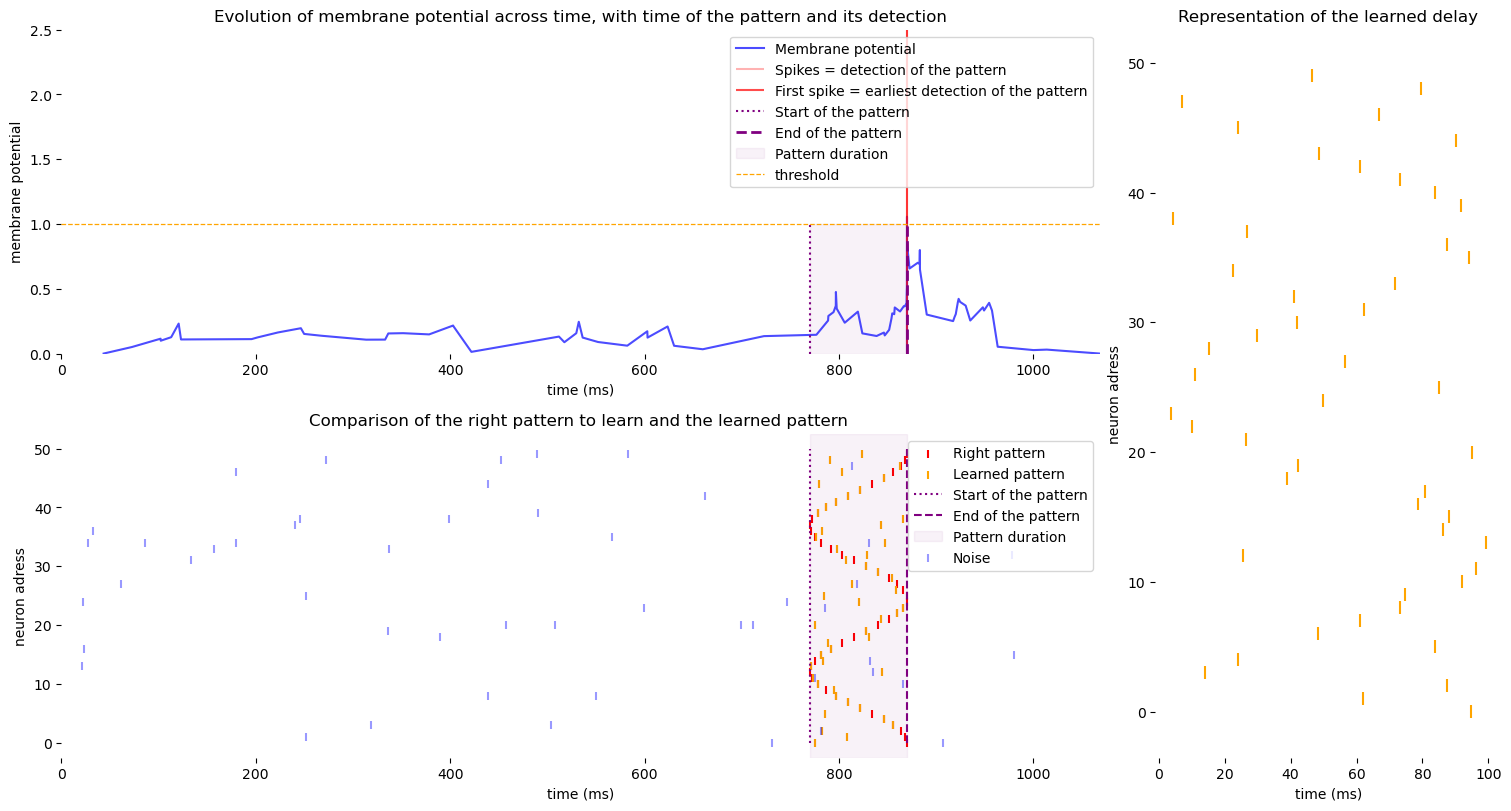

tau = 20 gain = 3.249999999999991
epoch: 70


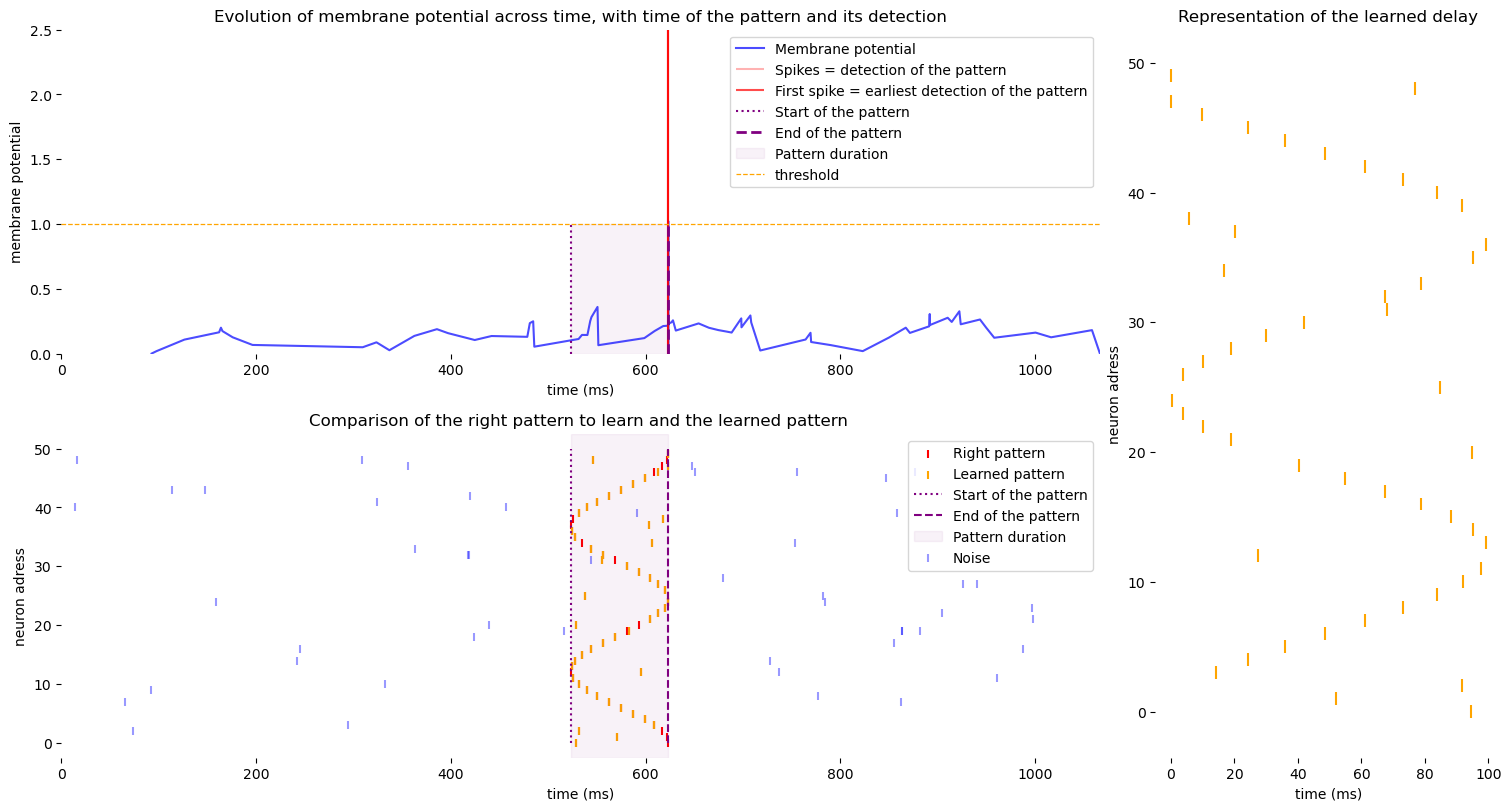

tau = 20 gain = 3.059999999999991
epoch: 80


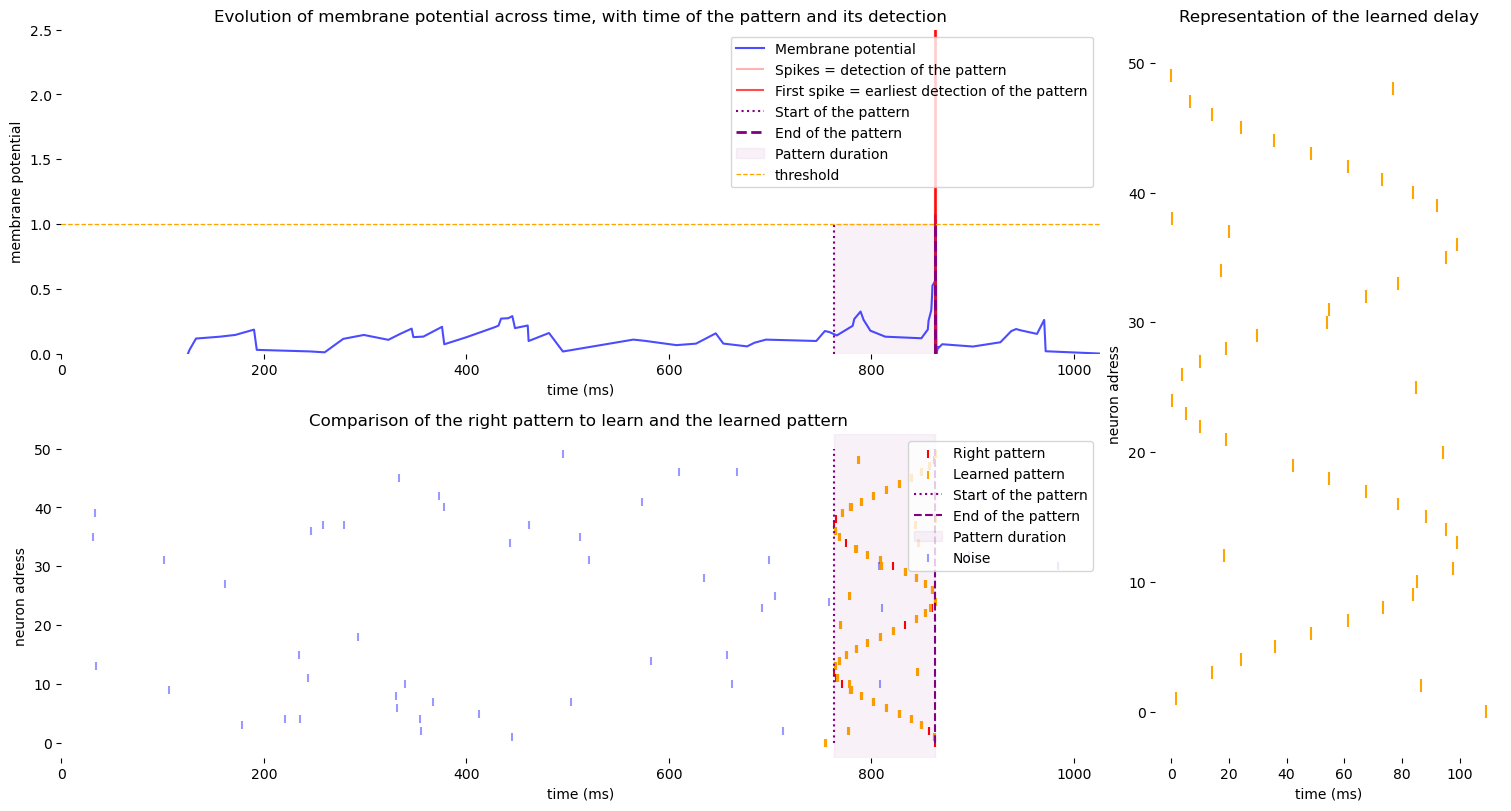

tau = 20 gain = 2.859999999999991
epoch: 90


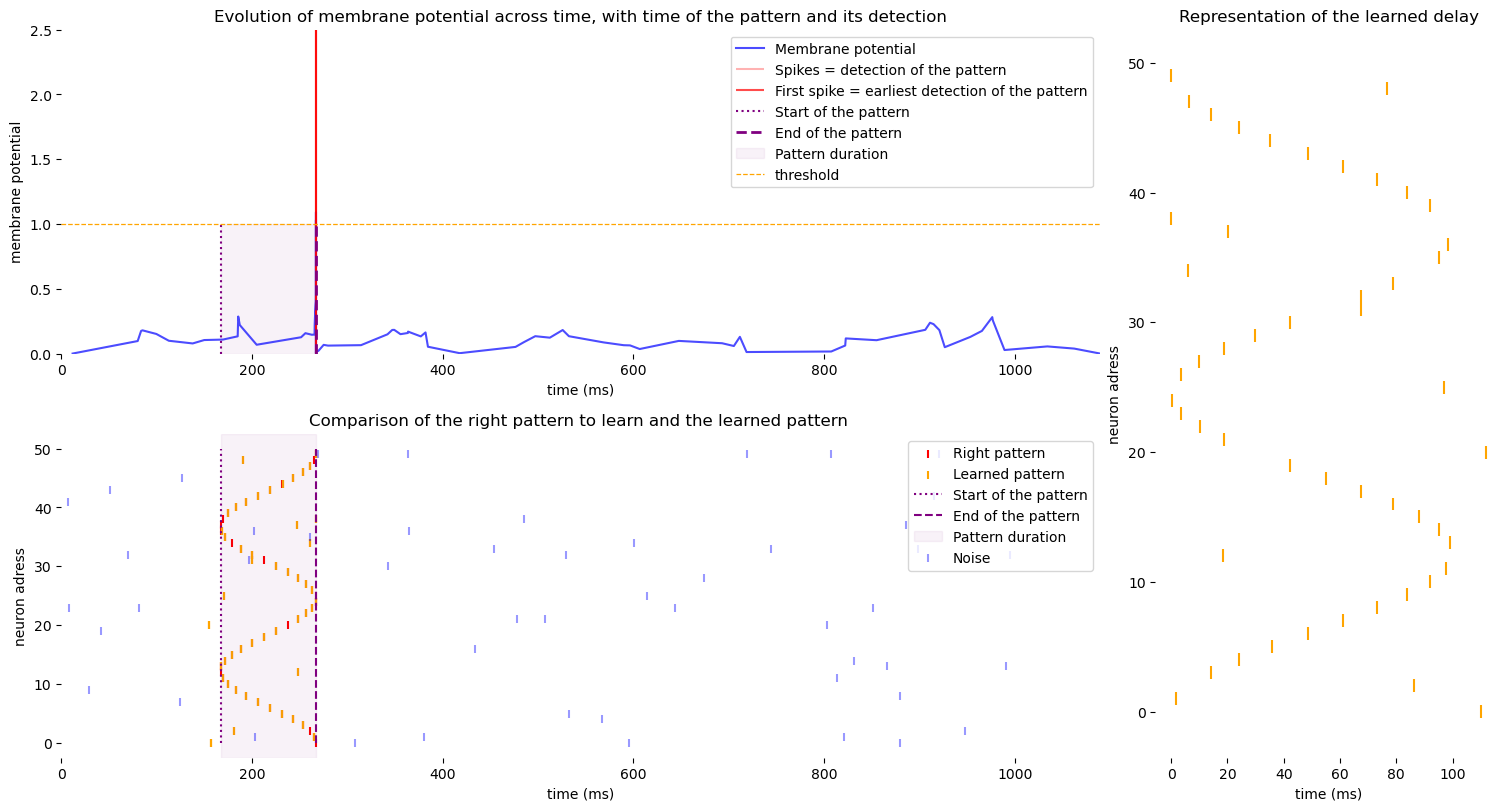

tau = 20 gain = 2.6999999999999917
epoch: 100


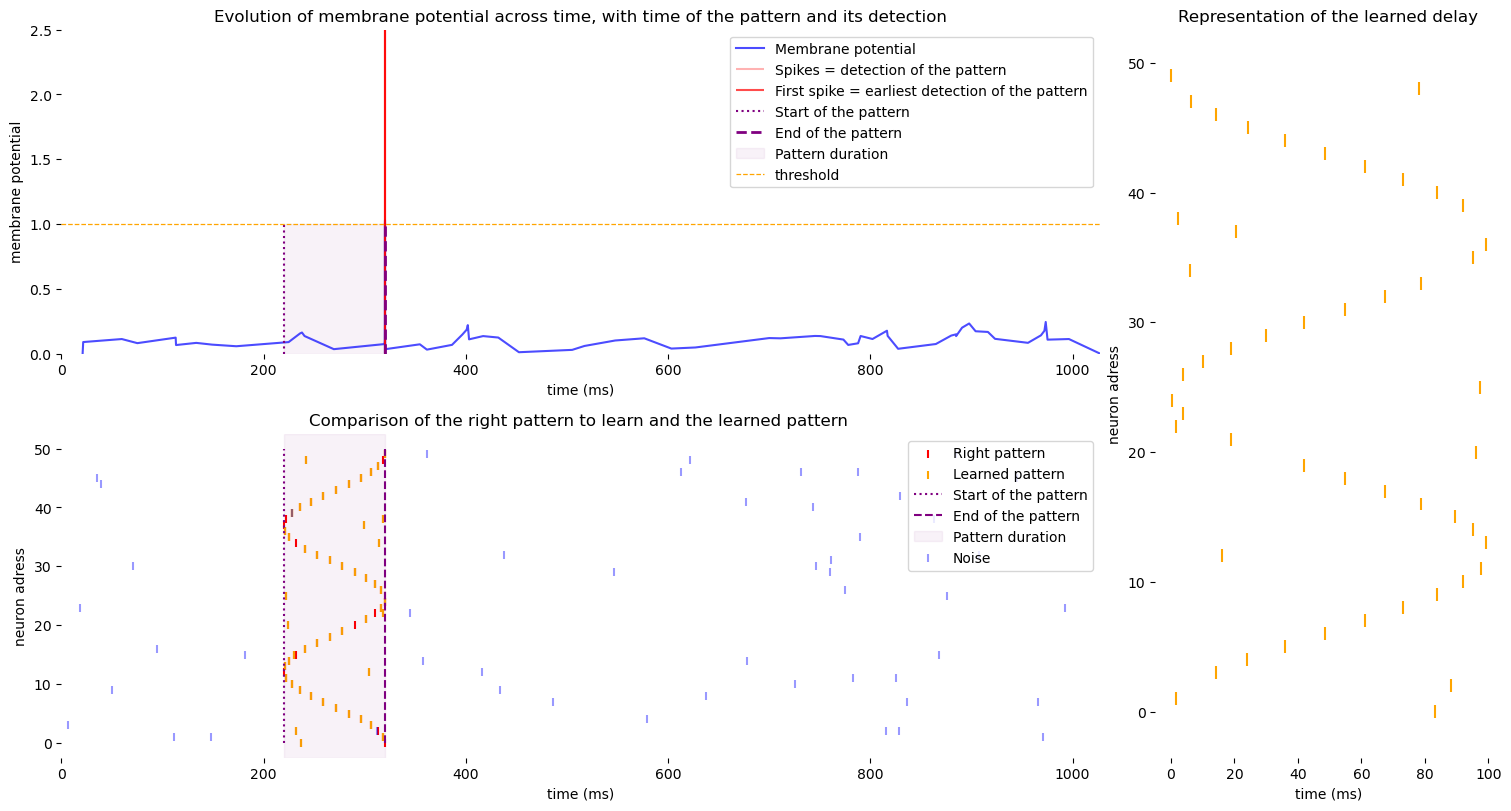

tau = 20 gain = 2.5899999999999936
epoch: 110


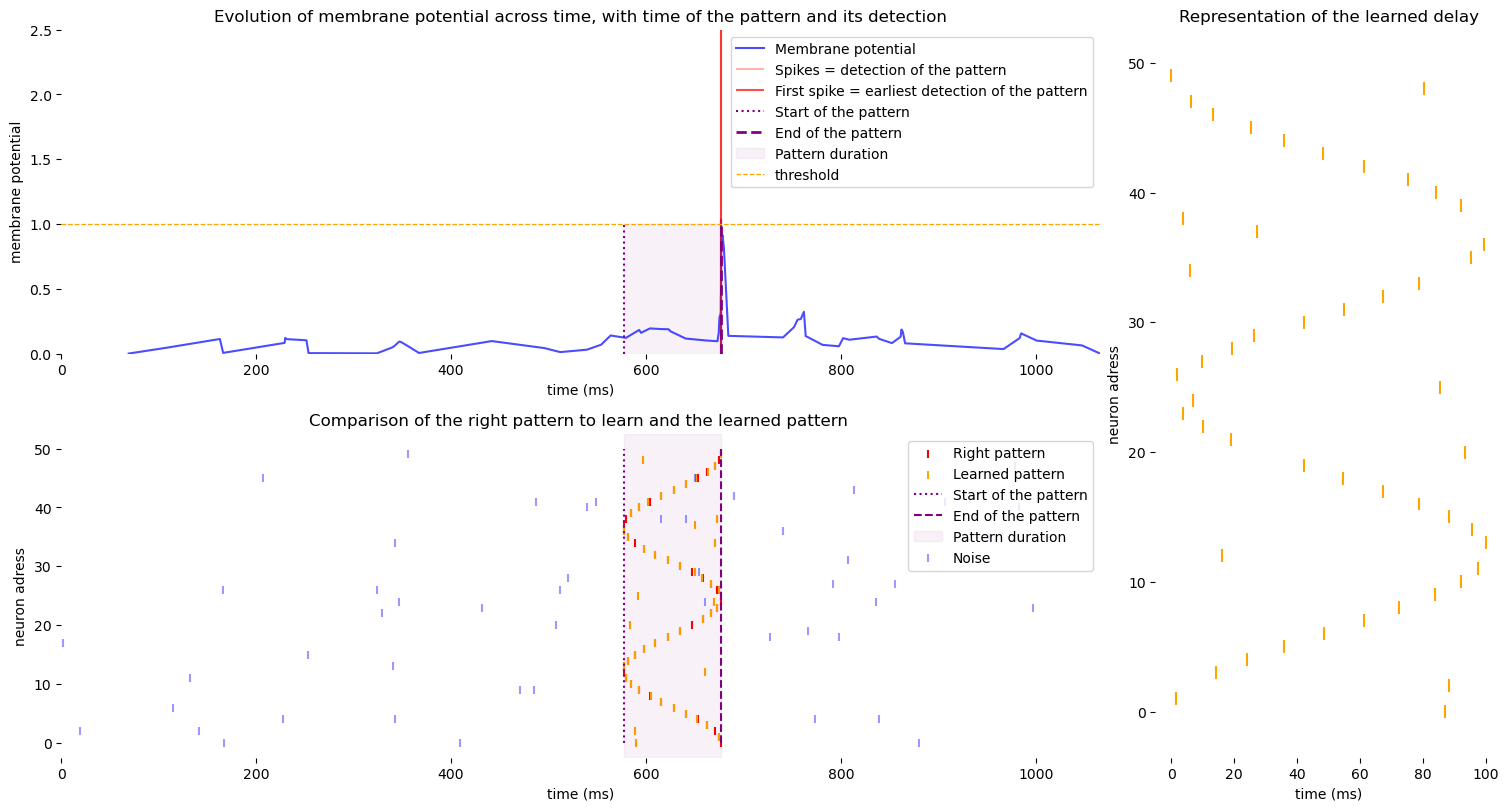

tau = 20 gain = 2.4899999999999958
epoch: 120


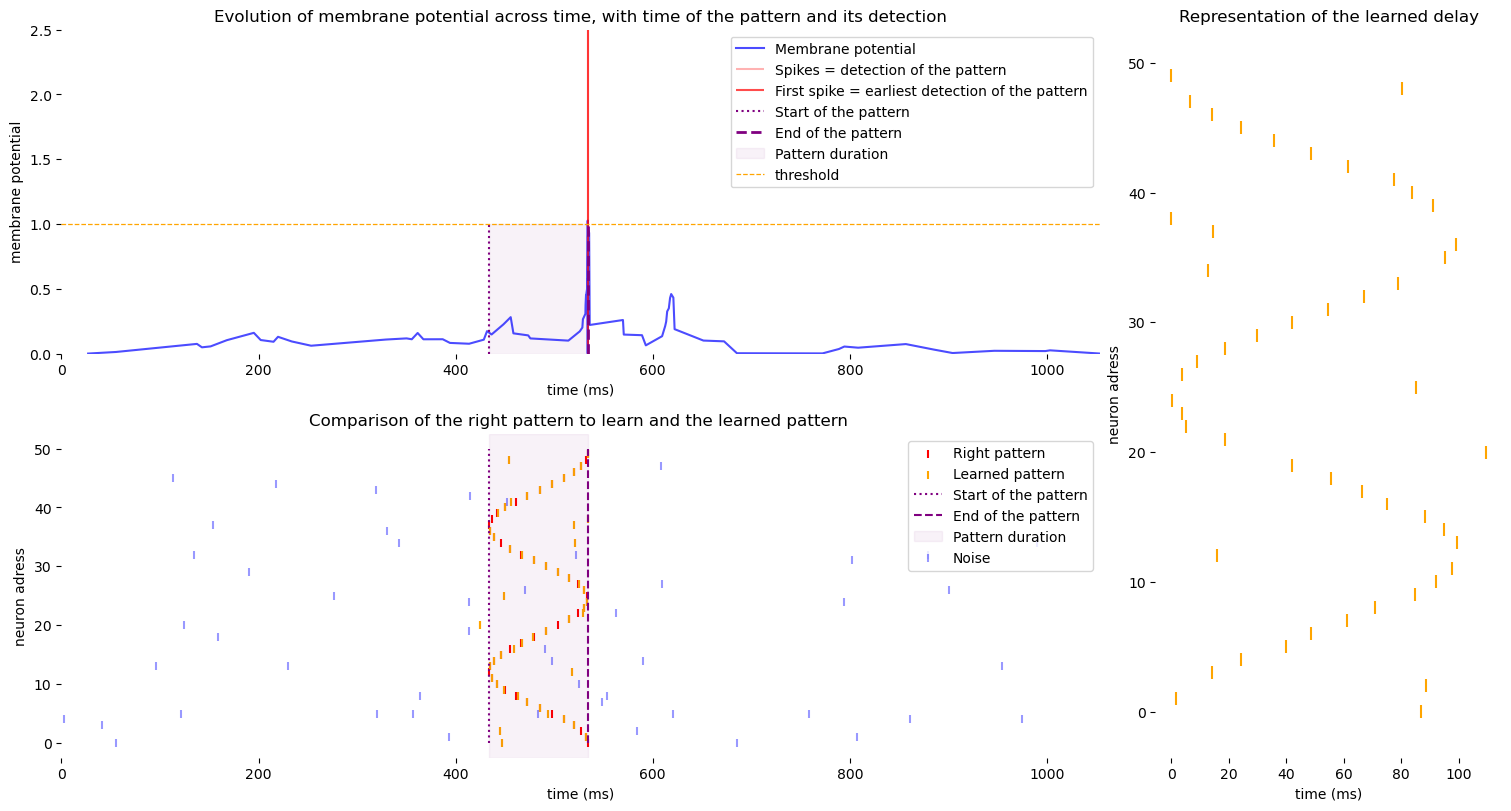

tau = 20 gain = 2.389999999999998
epoch: 130


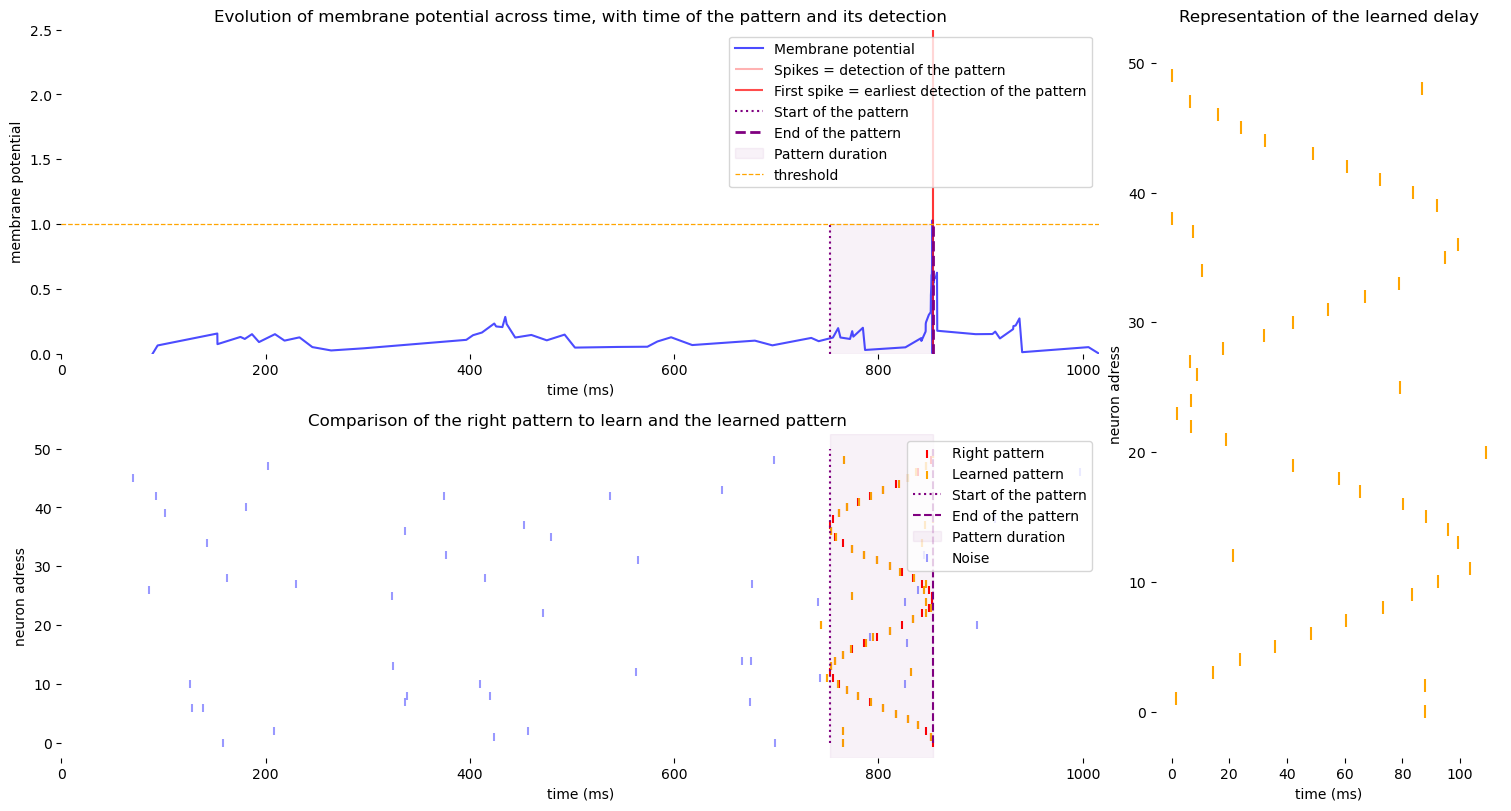

tau = 20 gain = 2.29
epoch: 140


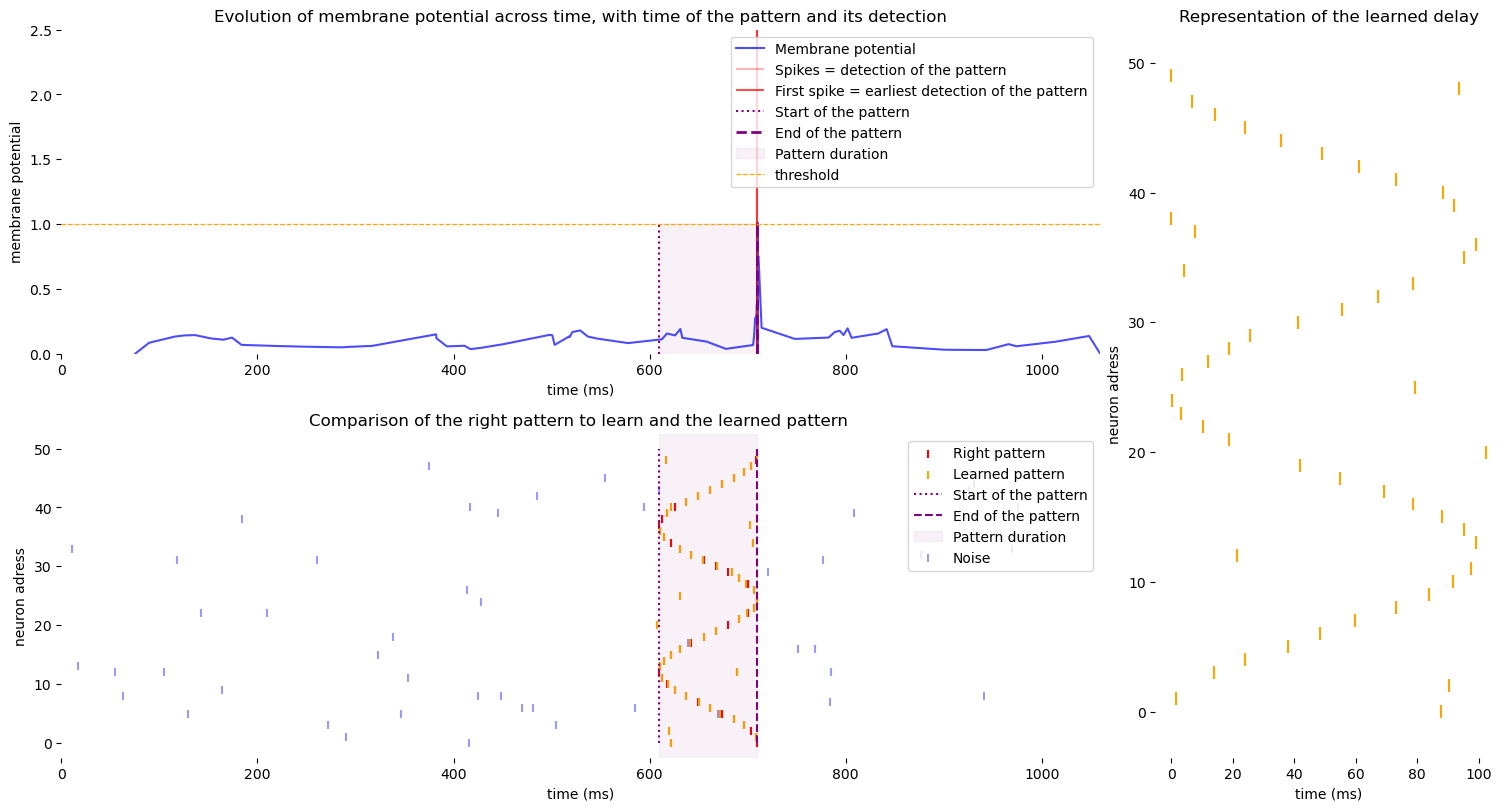

tau = 20 gain = 2.190000000000002
epoch: 150


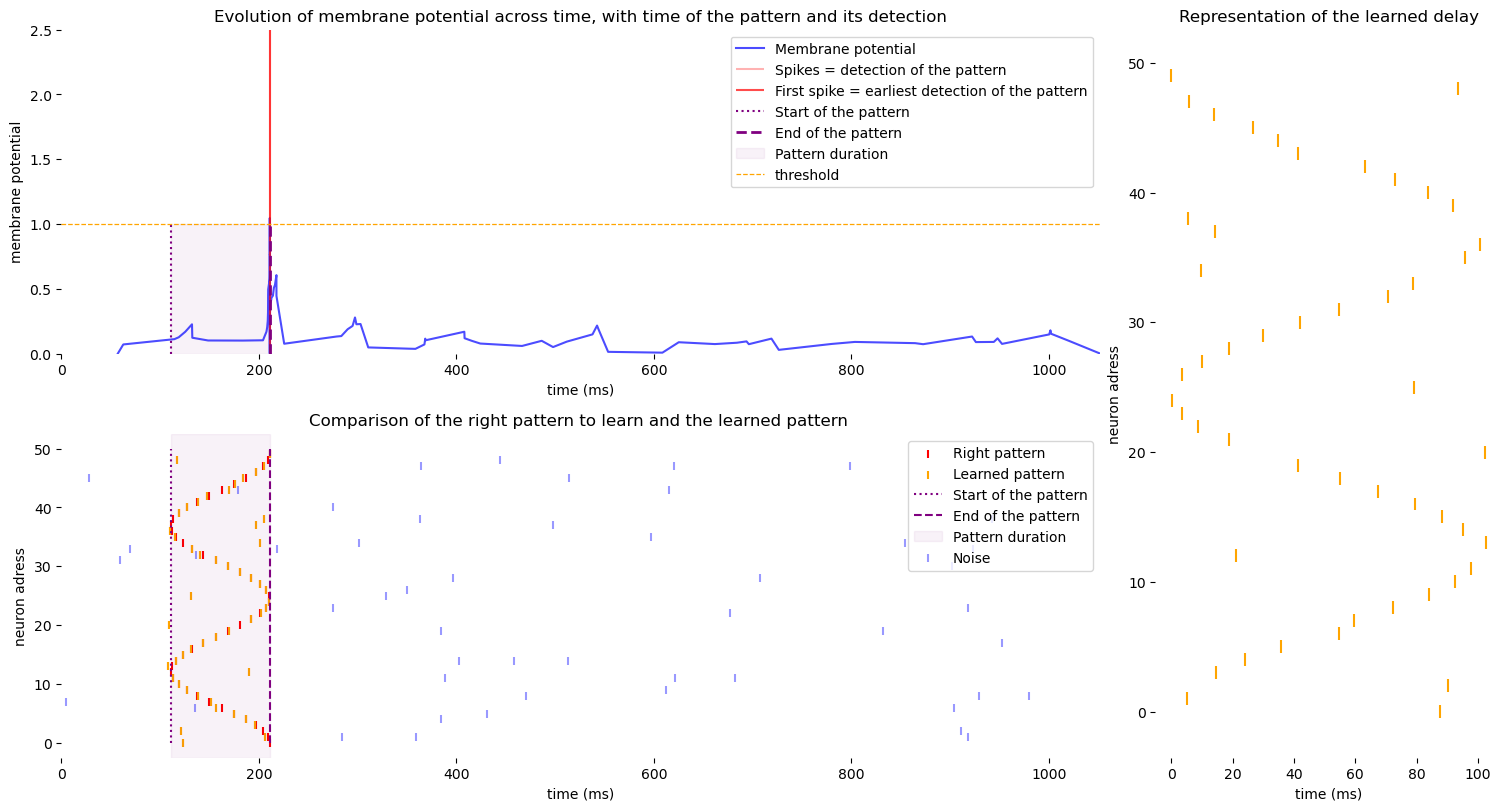

tau = 20 gain = 2.0900000000000043
epoch: 160


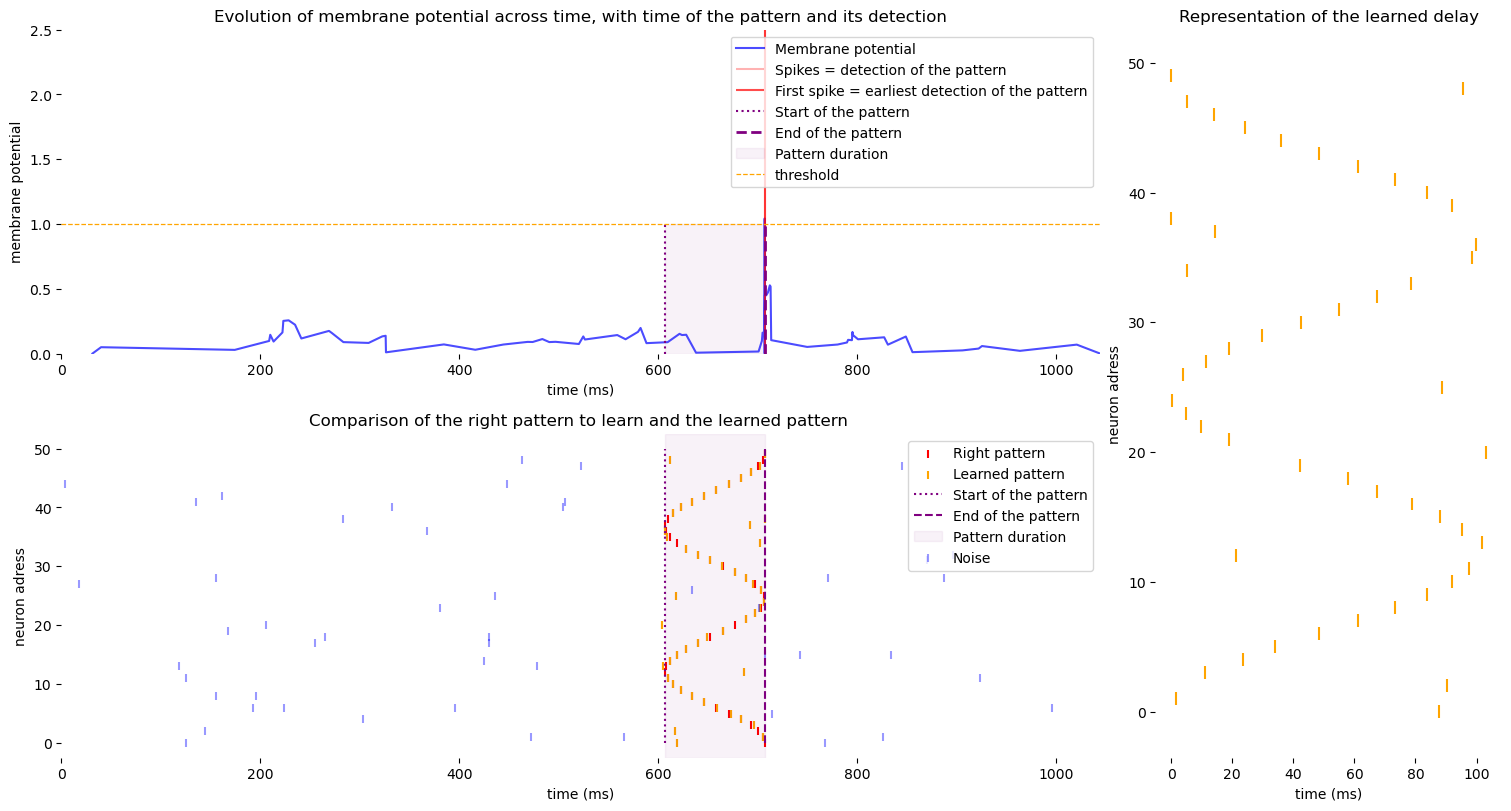

tau = 20 gain = 1.9900000000000062
epoch: 170


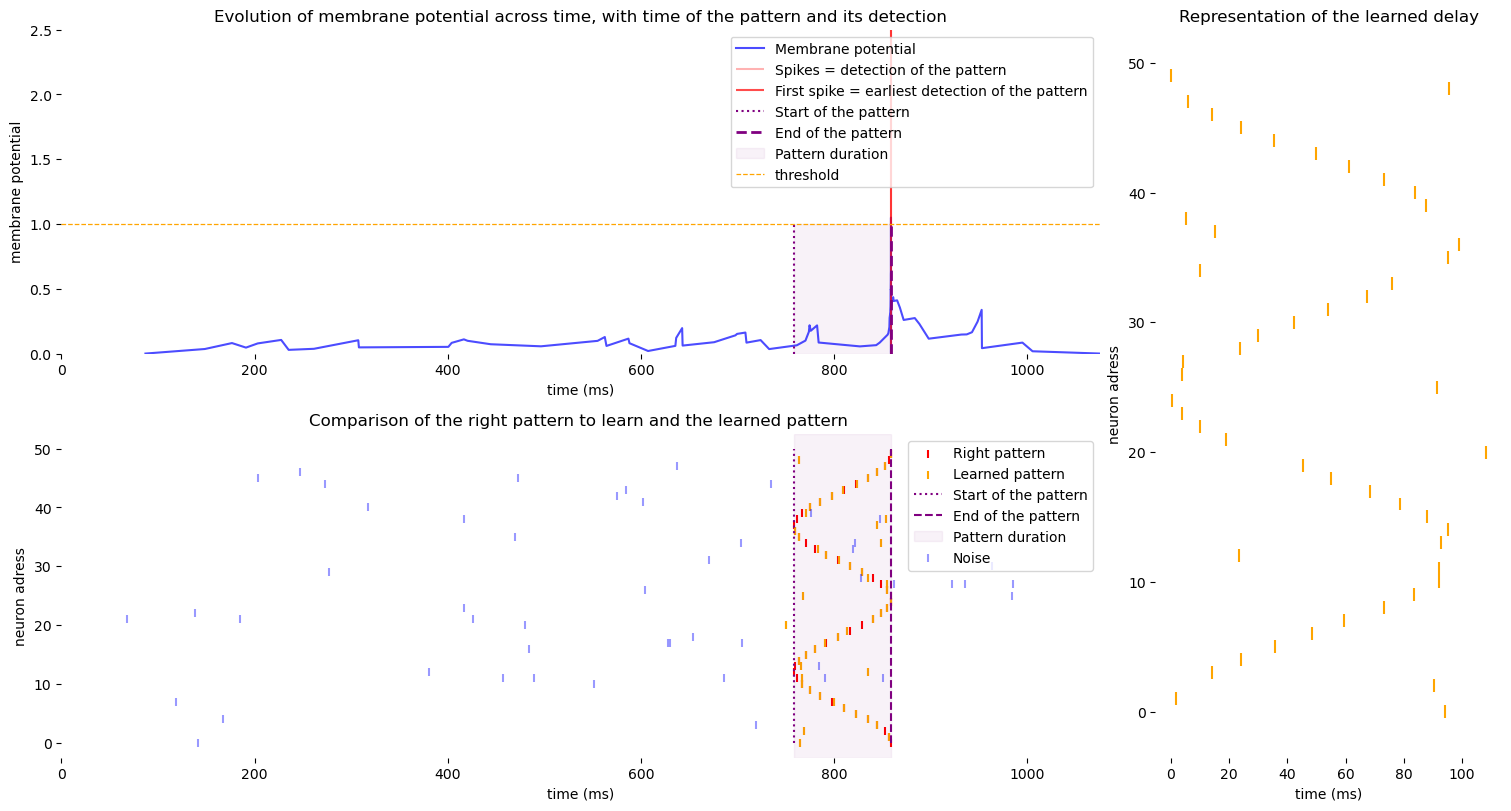

tau = 20 gain = 1.8900000000000061
epoch: 180


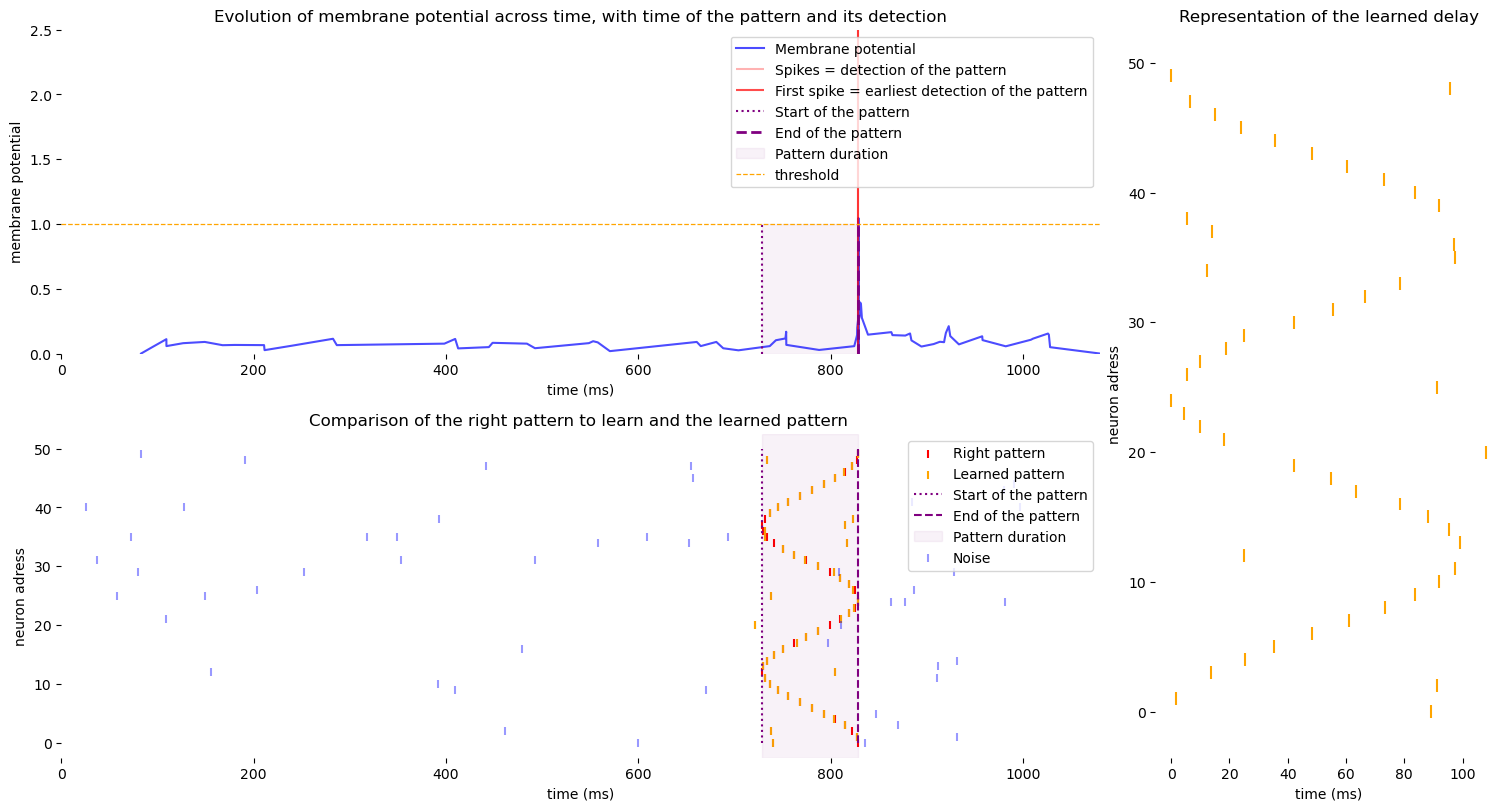

tau = 20 gain = 1.790000000000006
epoch: 190


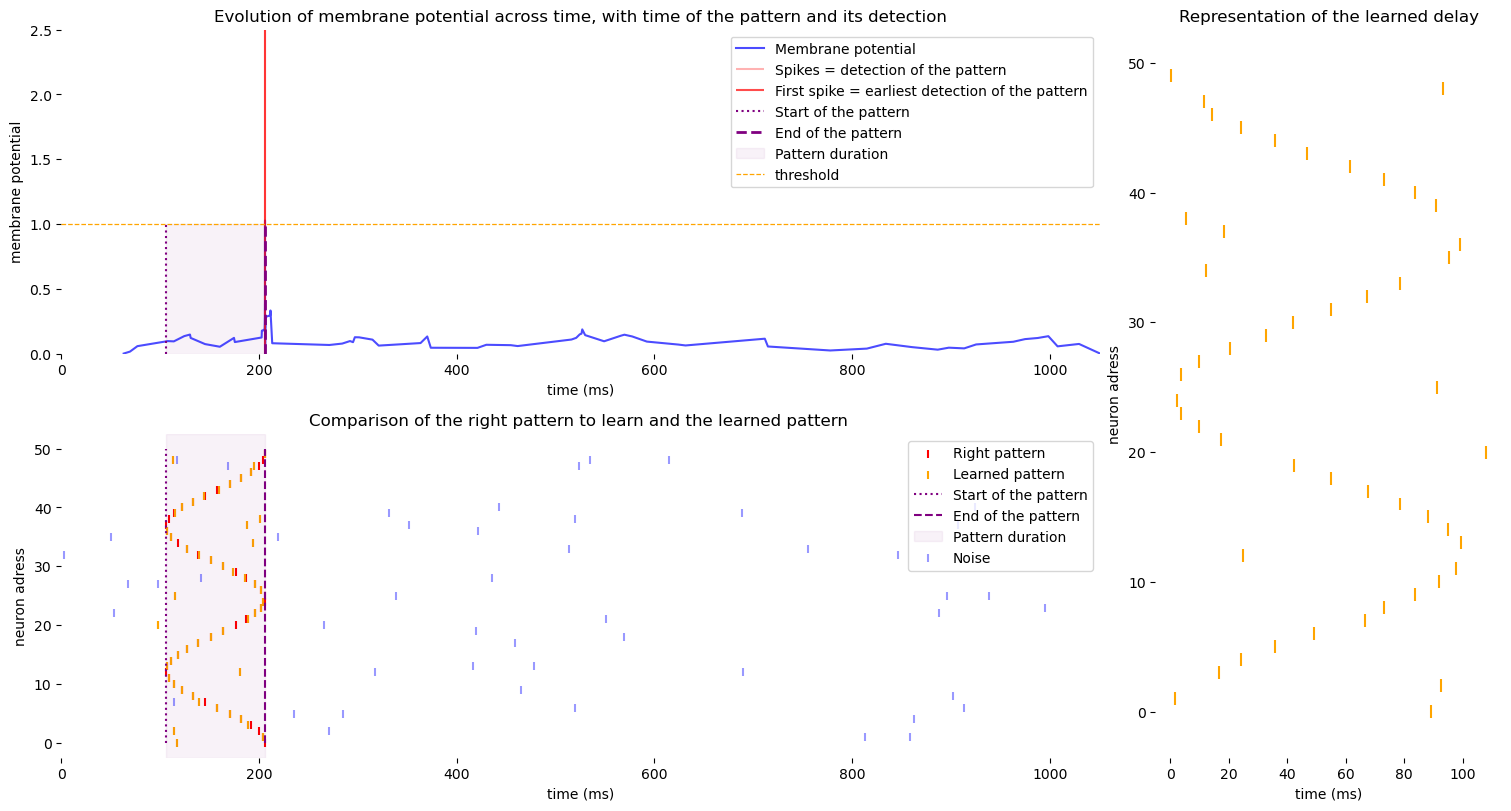

tau = 20 gain = 1.690000000000006
epoch: 200


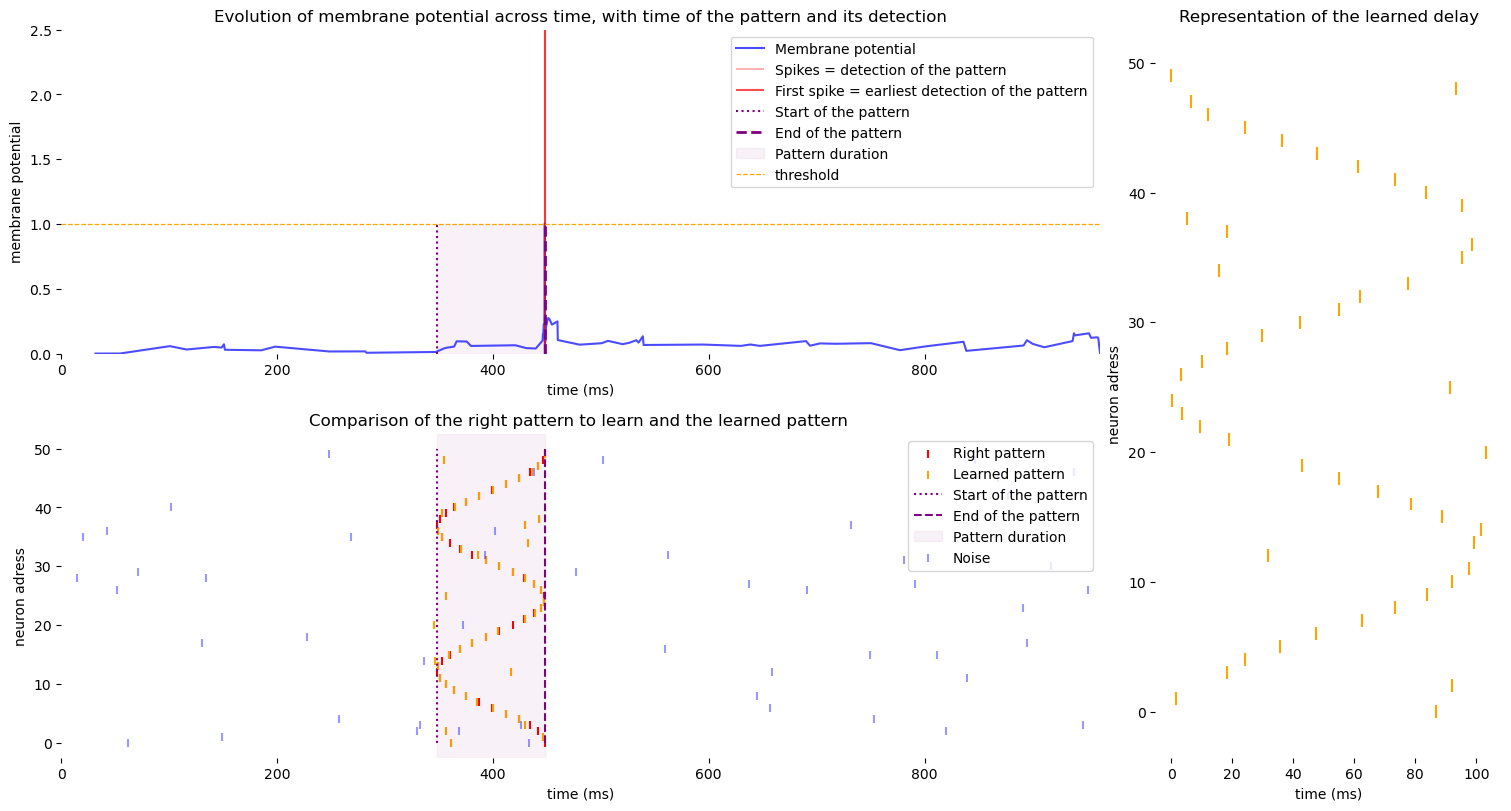

In [4]:
tau = 20 # delay_amplitude
gain = 3
pattern=cospattern

N = hsd_neuron(nb_synapses, tau = tau, gain = gain, delay_amplitude = delay_amplitude)

noise_density =  1e-3
learning_rate_tau = 1
learning_rate_gain = 0.01
learning_rate_delay = 0.1
N_epochs = 201
lambda_delay = .0001
momentum = .3

delay_gradient_history = np.zeros((N_epochs, len(N.delays)))
delays_history = np.zeros((N_epochs, len(N.delays)))

for i_epoch in range(N_epochs):
    t_true = delay_amplitude + int(np.random.rand()*(simulation_time-3*delay_amplitude)) # so this is the true number of pattern appearences

    aer_noise, aer_pattern, aer = make_input_aer(nb_synapses, noise_density, simulation_time, delay_amplitude, t_true, function = pattern)
    V, sorted_times, sorted_addresses, t_out = N.code(aer)

    output_spikes_number = len(t_out) # number of times the pattern triggered a repsonse fro mthe Lif neuron
    expected_output_spikes = len([t_true])
    
    if output_spikes_number==0: # if no spikes were triggered than tau (inverse decay) scales by the learning rate
#         N.tau += learning_rate_tau*expected_output_spikes
        N.gain += learning_rate_gain*expected_output_spikes
    else:
        for t_post in t_out:
            V_out = V[sorted_times==t_post]
            delay_gradient = delay_gradient_ = np.zeros([len(N.delays)])
            miles_delay_gradients = np.zeros([len(N.delays)])
            for add in range(len(N.delays)):
                spike_times = sorted_times[np.where(sorted_addresses==add)[0]]
                if len(spike_times)>0:
#                     delta_delay = t_post-N.delays[add]-spike_times#[spike_times<t_post+delay_amplitude]
#                     delay_function = N.weights[add]*np.sign(delta_delay)*absolute_kernel(delta_delay, N.tau)*N.gain
#                     delay_gradient[add] = (delay_function).sum()
#                     #print(delay_gradient)
#                     delay_gradient[add] += lambda_delay*N.delays[add]
                    miles_delay_gradients[add] = np.sum(STDP_weight(spike_times-(t_true+delay_amplitude),tau))
                
            delay_gradient_ = momentum * delay_gradient_ + (1-momentum)*miles_delay_gradients
            N.delays += learning_rate_delay*delay_gradient_*delay_amplitude
            N.delays[N.delays<0]=0
            #if np.linalg.norm(N.delays)!=0:
            #    N.delays *= delay_amplitude/np.linalg.norm(N.delays)
            
            delay_gradient_history[i_epoch] = delay_gradient_
            delays_history[i_epoch] = N.delays
        
#         N.tau += learning_rate_tau*(expected_output_spikes-(output_spikes_number+1))
        N.gain += learning_rate_gain*(expected_output_spikes-(output_spikes_number+1))
    if i_epoch % (N_epochs//20) == 0:
        print('tau = ' + str(N.tau), 'gain = ' + str(N.gain))
        print('epoch: ' + str(i_epoch))
        plot_learning_figure(sorted_times, V, N, t_out, np.array([t_true]), delay_amplitude, aer_noise, aer_pattern, delay_gradient=None)


In [5]:
saved_delays = N.delays

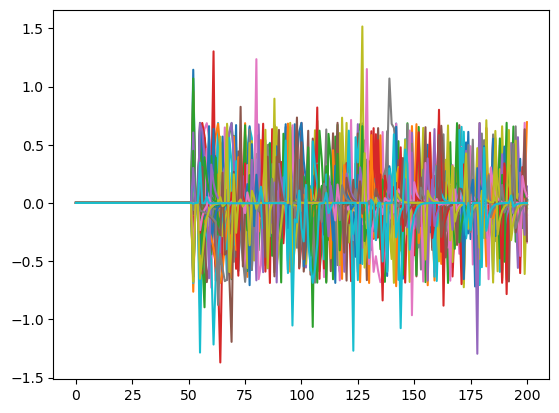

In [84]:
plt.figure()
plt.plot(delay_gradient_history)
plt.show()

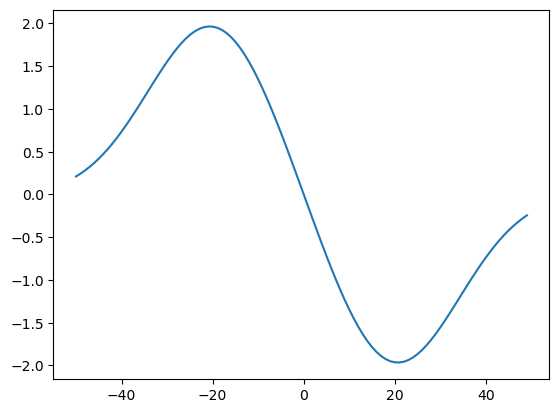

0.2190685972419603


In [26]:
test = np.arange(-500,500)
test_spikes = np.random.randint(999,size=(5,1))-500
plt.figure()
plt.plot(test[450:550],STDP_weight(test,tau)[450:550])
# plt.scatter(test_spikes,STDP_weight(test_spikes,tau),marker='x',color='orange')
plt.show()
print(np.sum(STDP_weight(test_spikes,tau)))

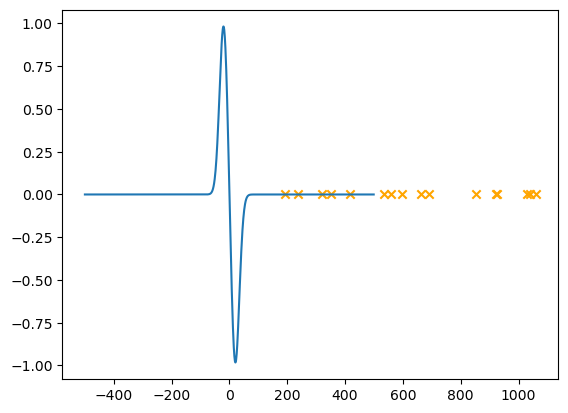

In [17]:
plt.plot(test,STDP_weight(test,tau))
plt.scatter(spike_times,STDP_weight(spike_times,tau),marker='x',color='orange')
plt.show()

In [3]:
from brainhack import *
import numpy as np
import matplotlib.pyplot as plt
import random

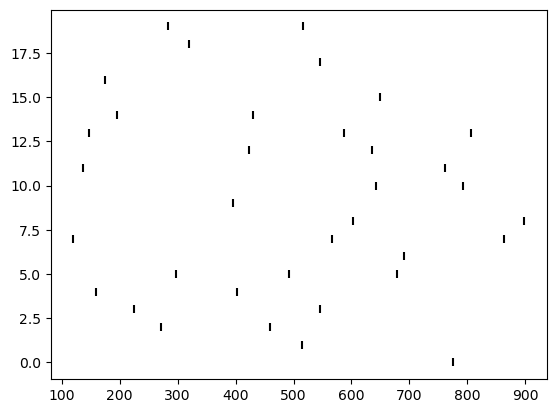

In [4]:
fs = 2 # in hz (occurrences per 1000 time points)
T = 1000
time = np.arange(0,T)
N = 20
h = []
plt.figure()
for n in range(N):
    events, addresses = poisson(fs,T,refractory=150,event_duration=100)    
    plt.scatter(events,[n for k in events],marker='|',color='black')
    
plt.show()


In [19]:
nb_synapses, noise_density, simulation_time, fs = 50, 100e-3, 1e3, 2
pattern_temporal_amplitude = delay_amplitude = 100
pattern = linear


t_true = poisson(fs,simulation_time,refractory=100)[0]
t_true = t_true[t_true <900]
print(t_true)

pattern_times = poisson(fs,simulation_time,refractory=100,event_duration=100)
aer_noise, aer_pattern, aer = make_spiketrains_motif(nb_synapses, noise_density, simulation_time, pattern_temporal_amplitude, t_true, function=pattern)
# fig, ax = plot_input(time_pattern, aer_pattern)



[290.]


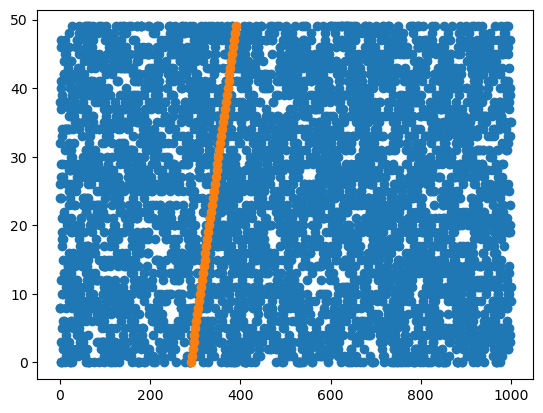

In [20]:
test = np.arange(0, simulation_time)
plt.figure()
plt.scatter(aer_noise[1], aer_noise[0])
plt.scatter(aer_pattern[1], aer_pattern[0])
# plt.scatter(all_timestamps,all_adresses)
# plt.scatter(aer[1], aer[0])
plt.show()

tau = 20 gain = 2.88
epoch: 0
error: 2.4


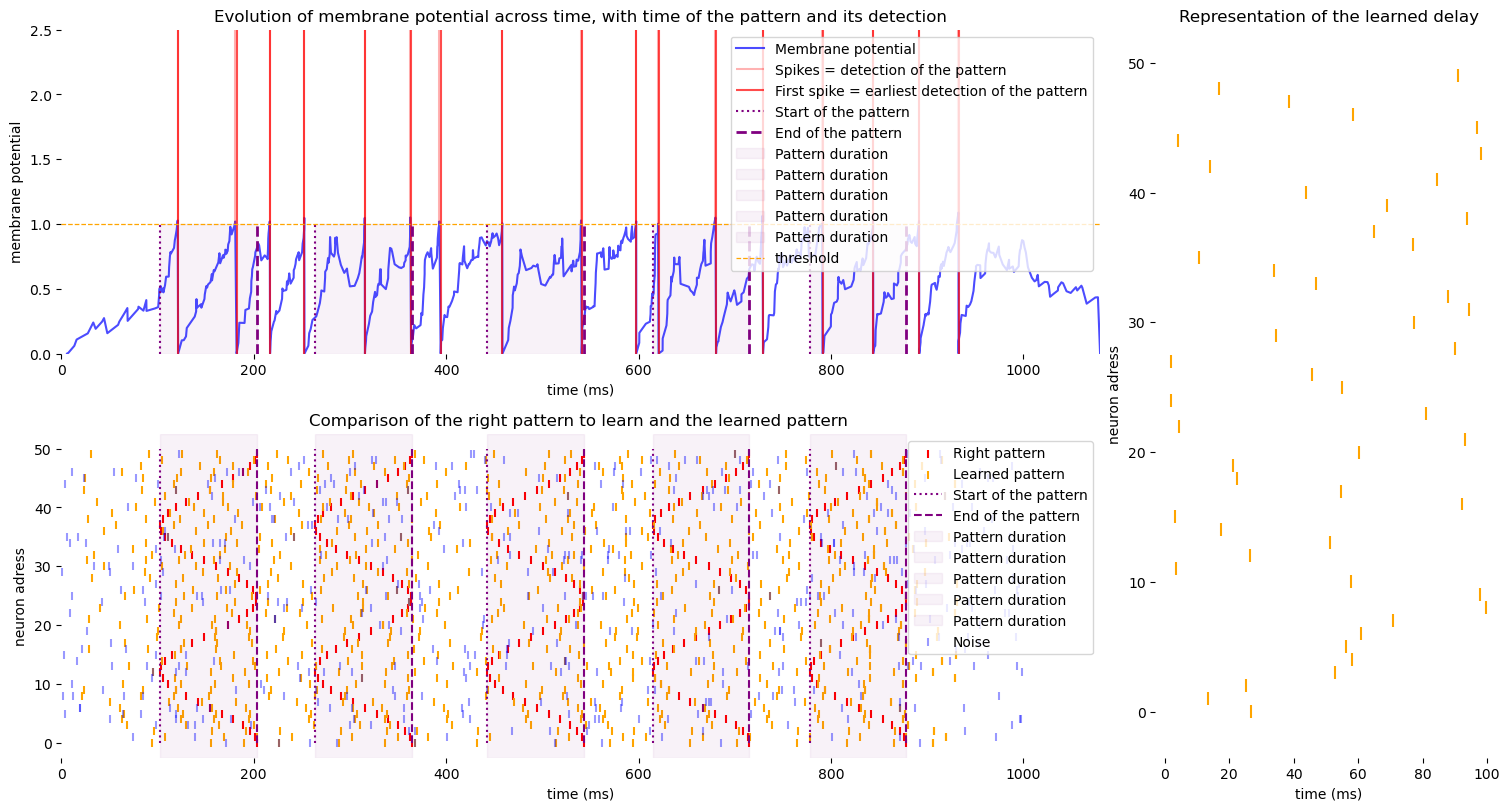

tau = 20 gain = 2.3100000000000014
epoch: 20
error: 0.0


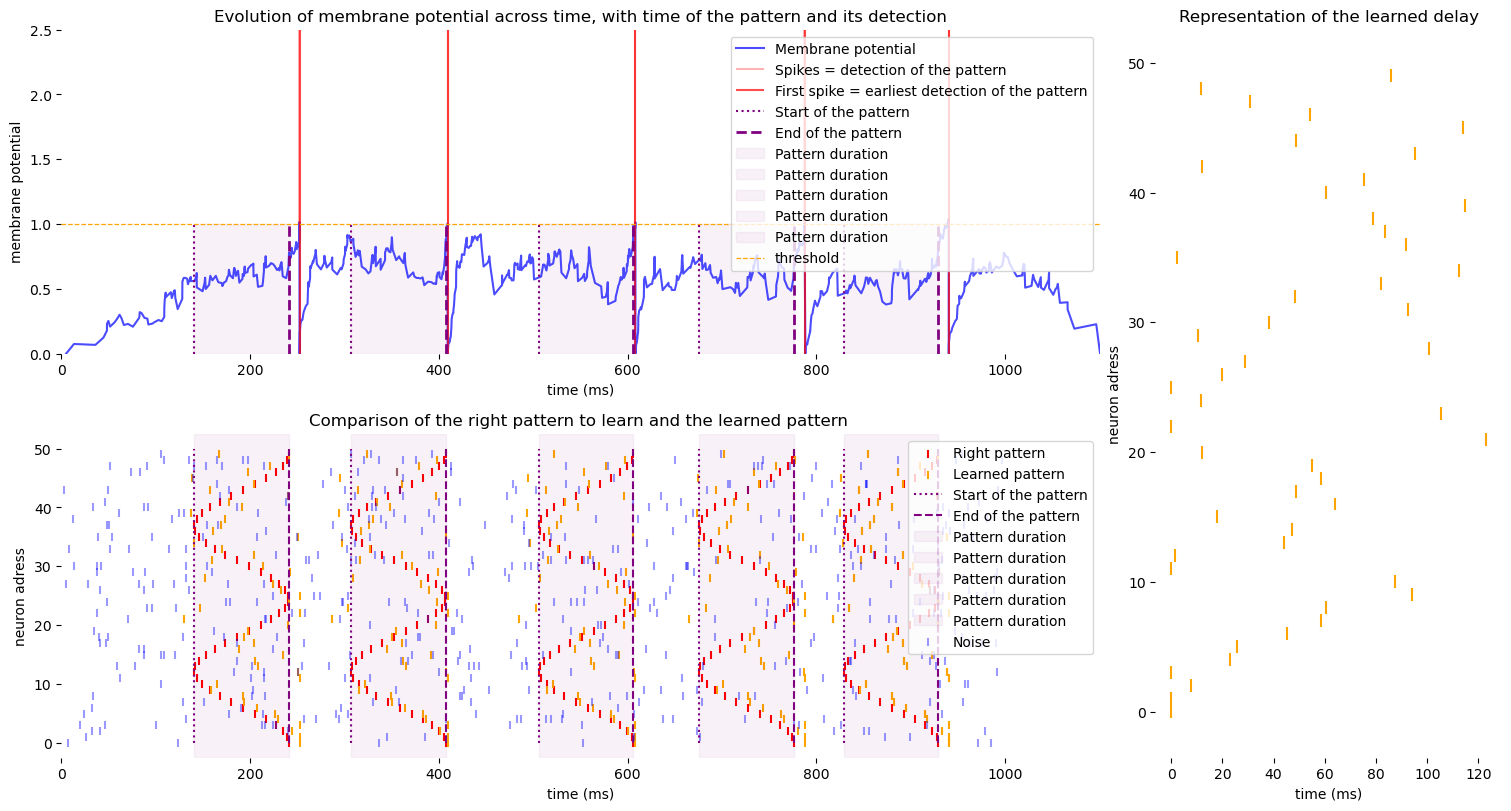

tau = 20 gain = 2.1900000000000026
epoch: 40
error: 0.19999999999999996


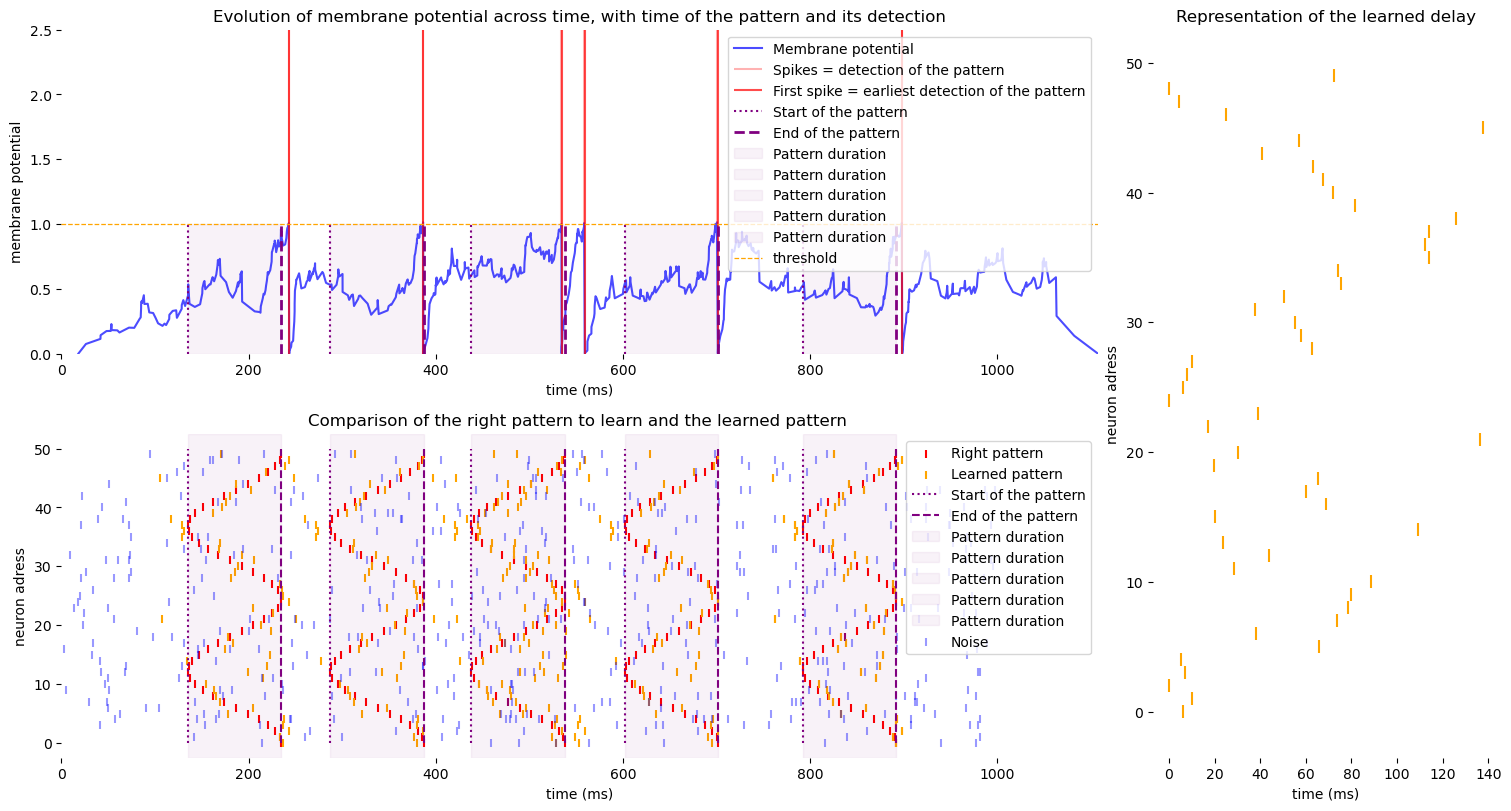

tau = 20 gain = 2.0100000000000047
epoch: 60
error: 0.25


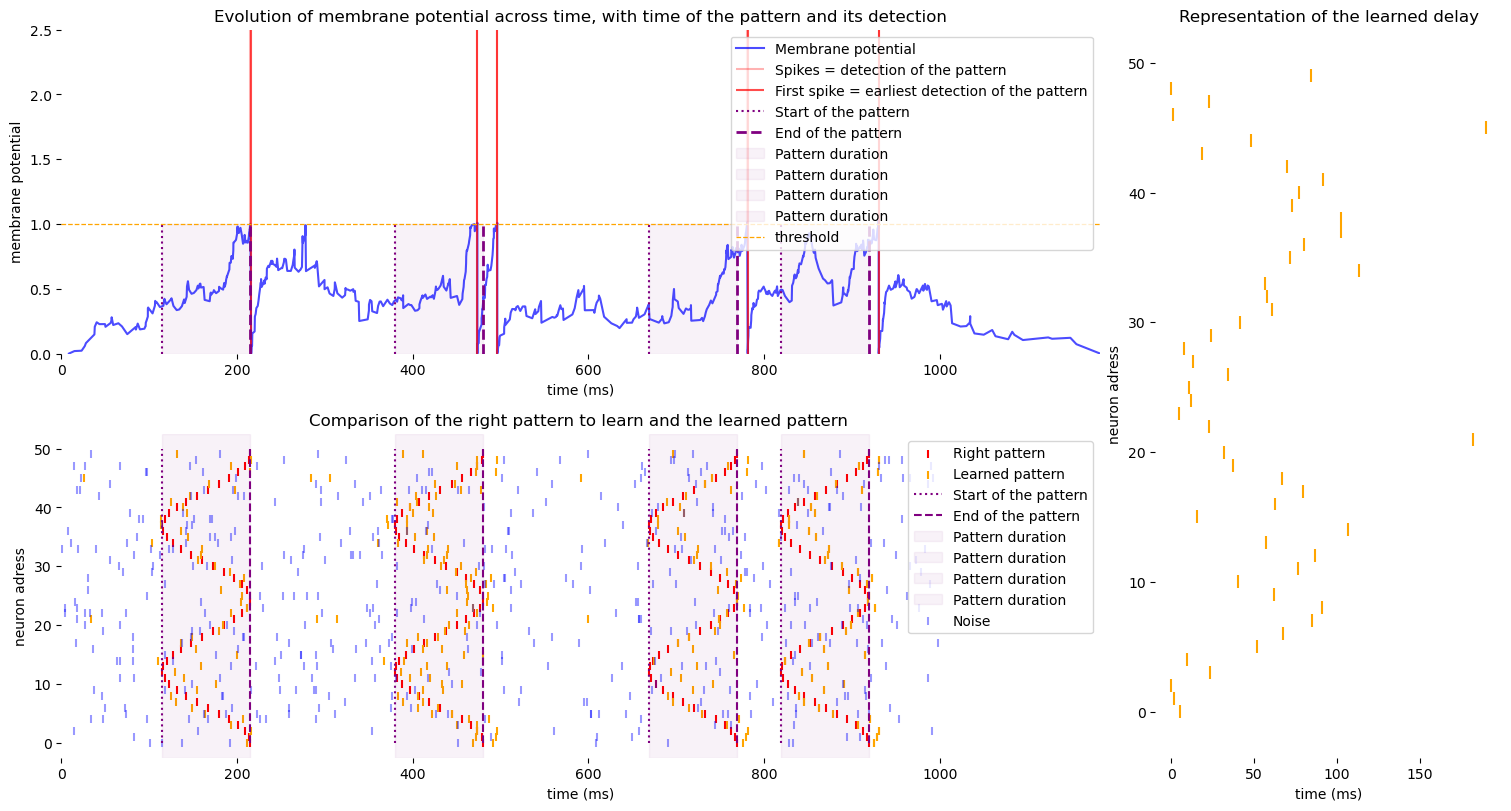

tau = 20 gain = 1.9400000000000048
epoch: 80
error: 0.0


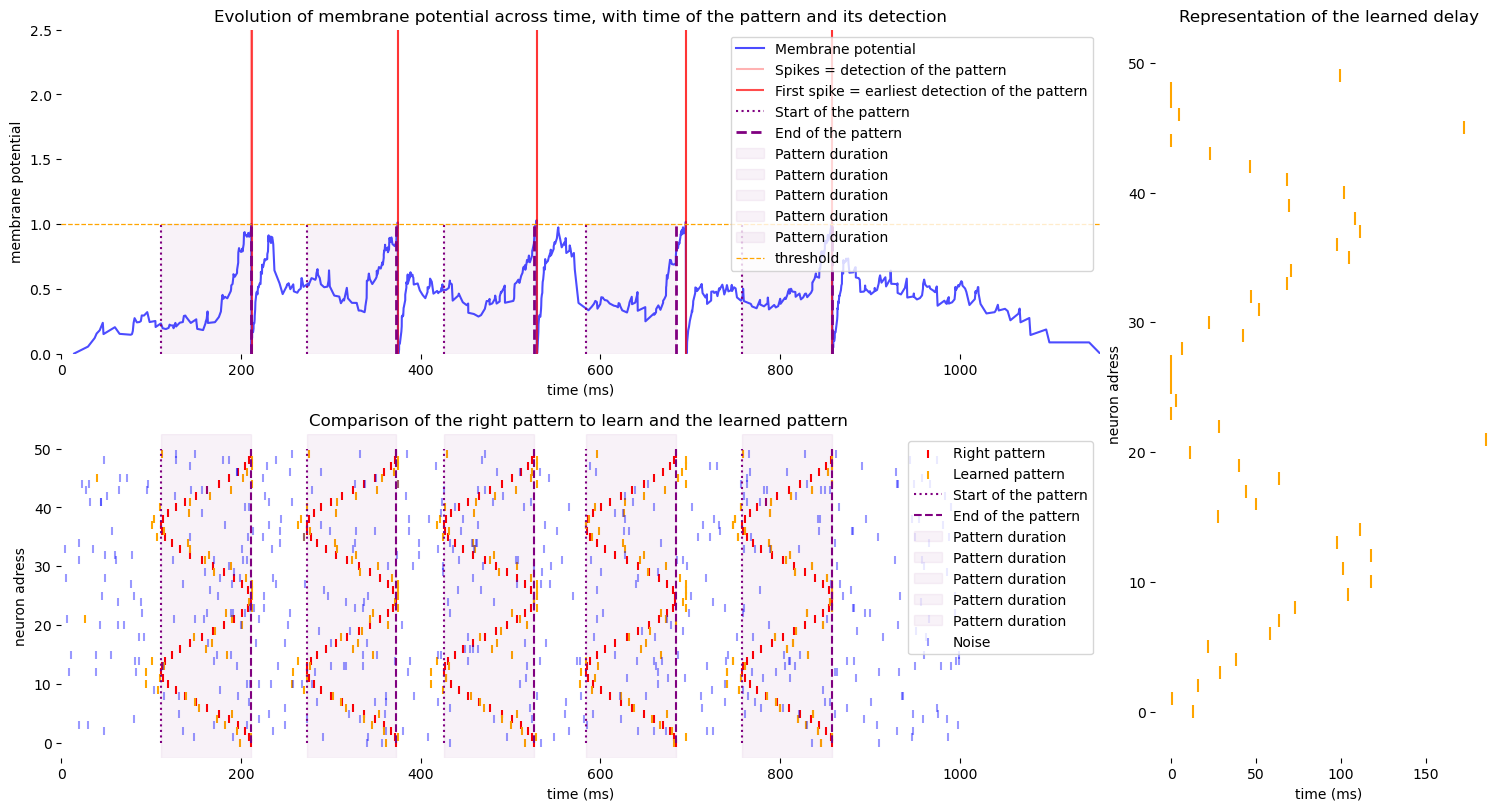

tau = 20 gain = 1.8900000000000048
epoch: 100
error: 0.0


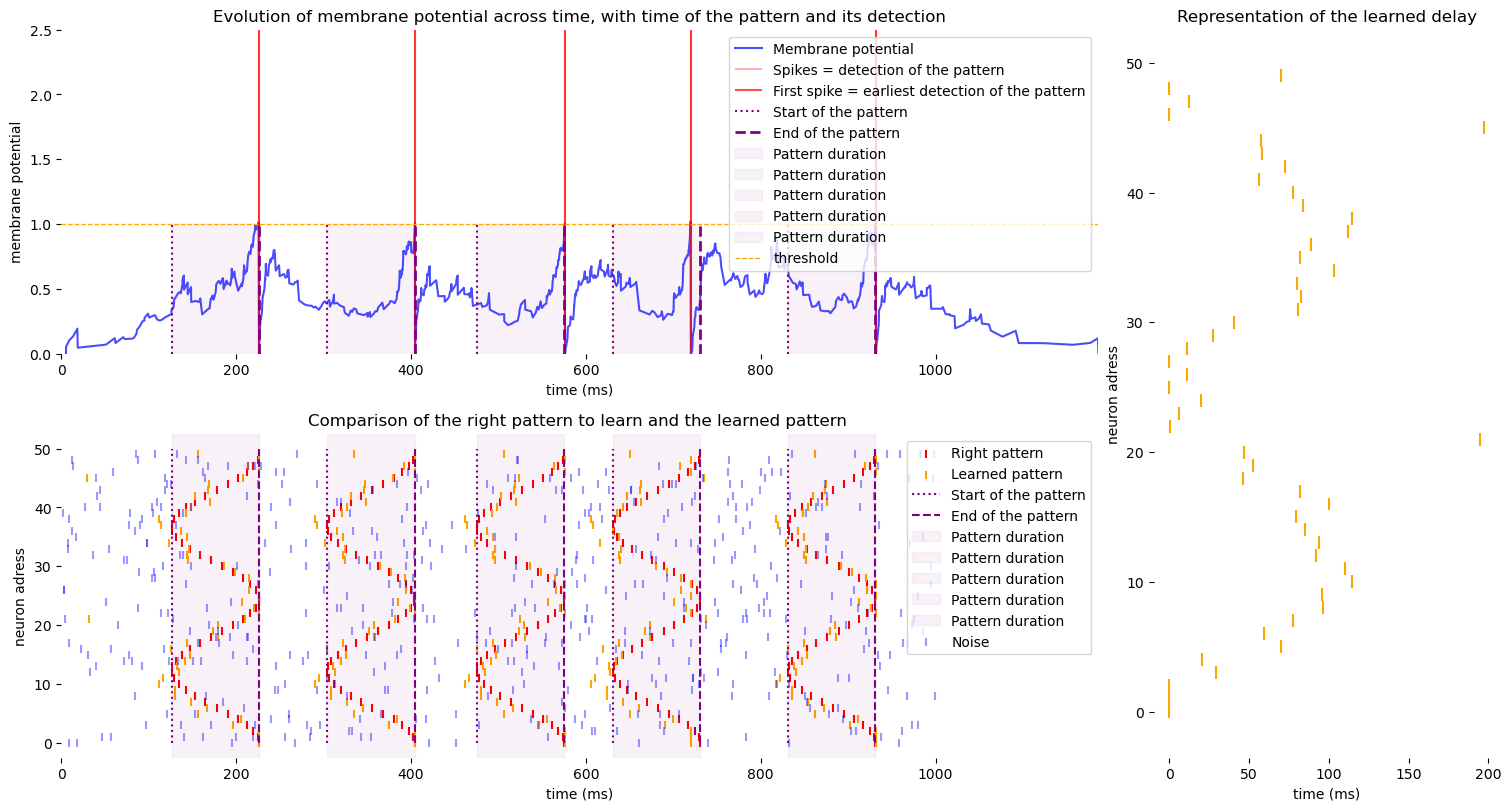

tau = 20 gain = 1.8700000000000048
epoch: 120
error: 0.19999999999999996


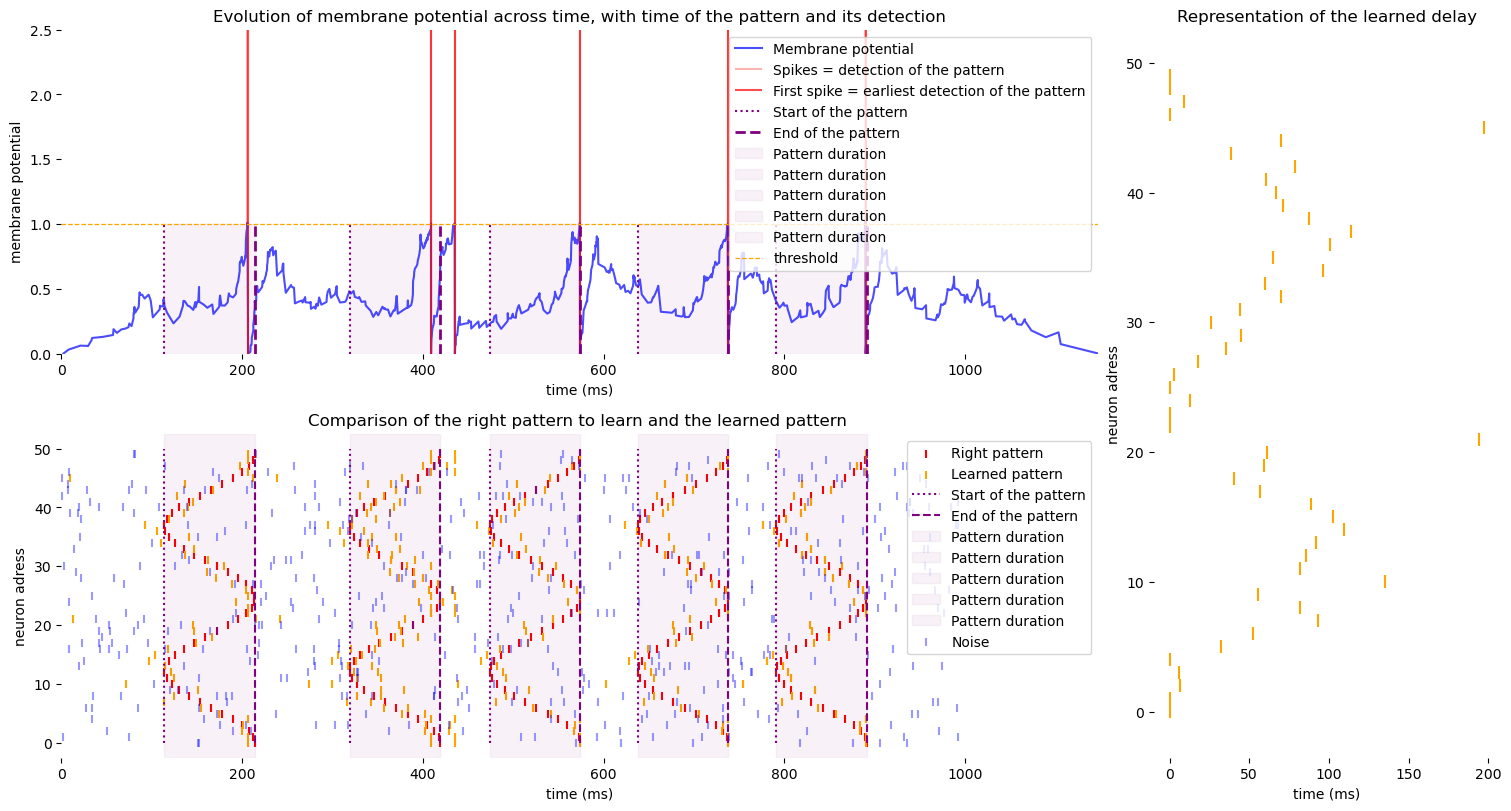

tau = 20 gain = 1.8600000000000048
epoch: 140
error: 0.0


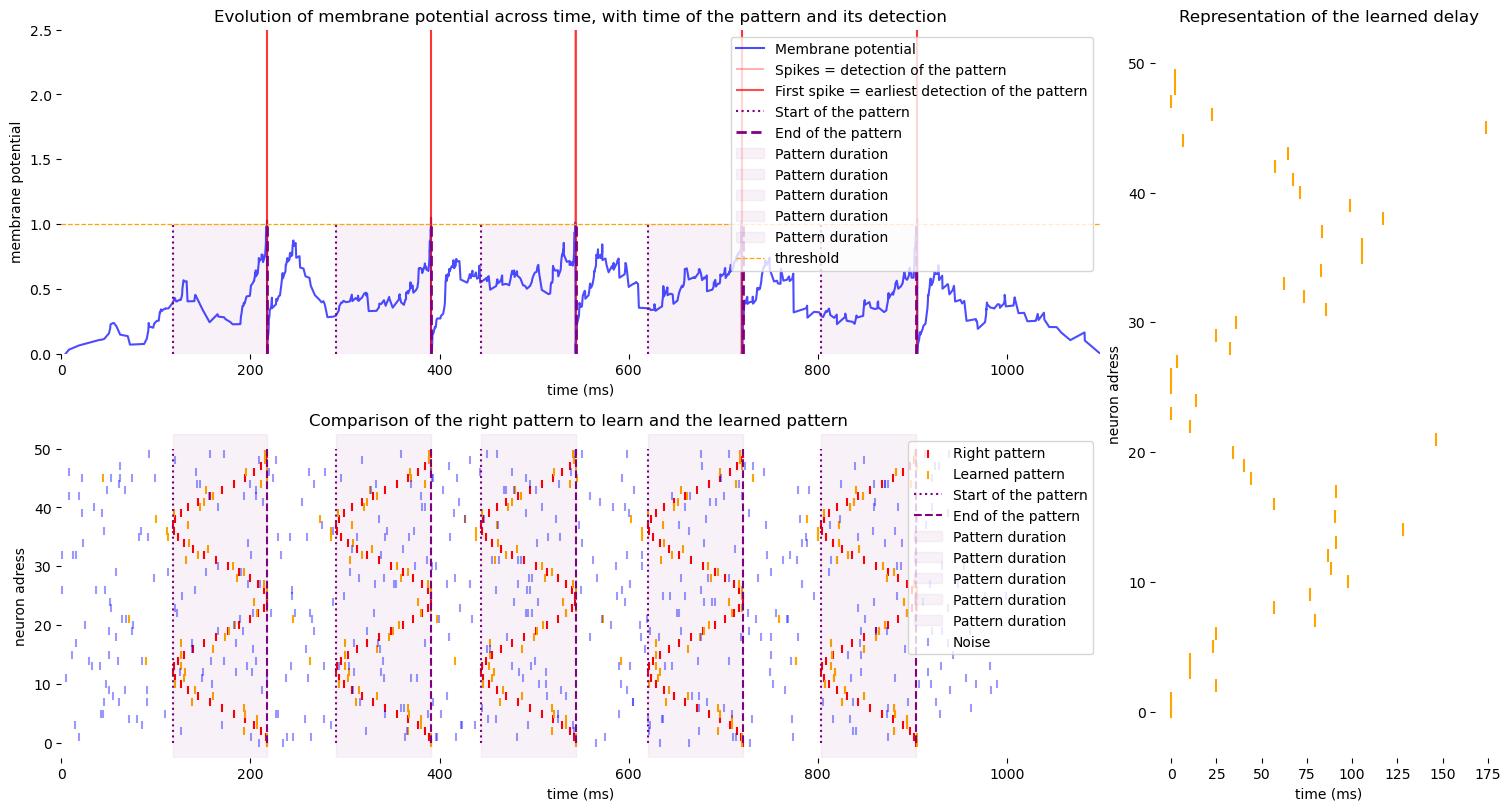

tau = 20 gain = 1.8500000000000048
epoch: 160
error: 0.0


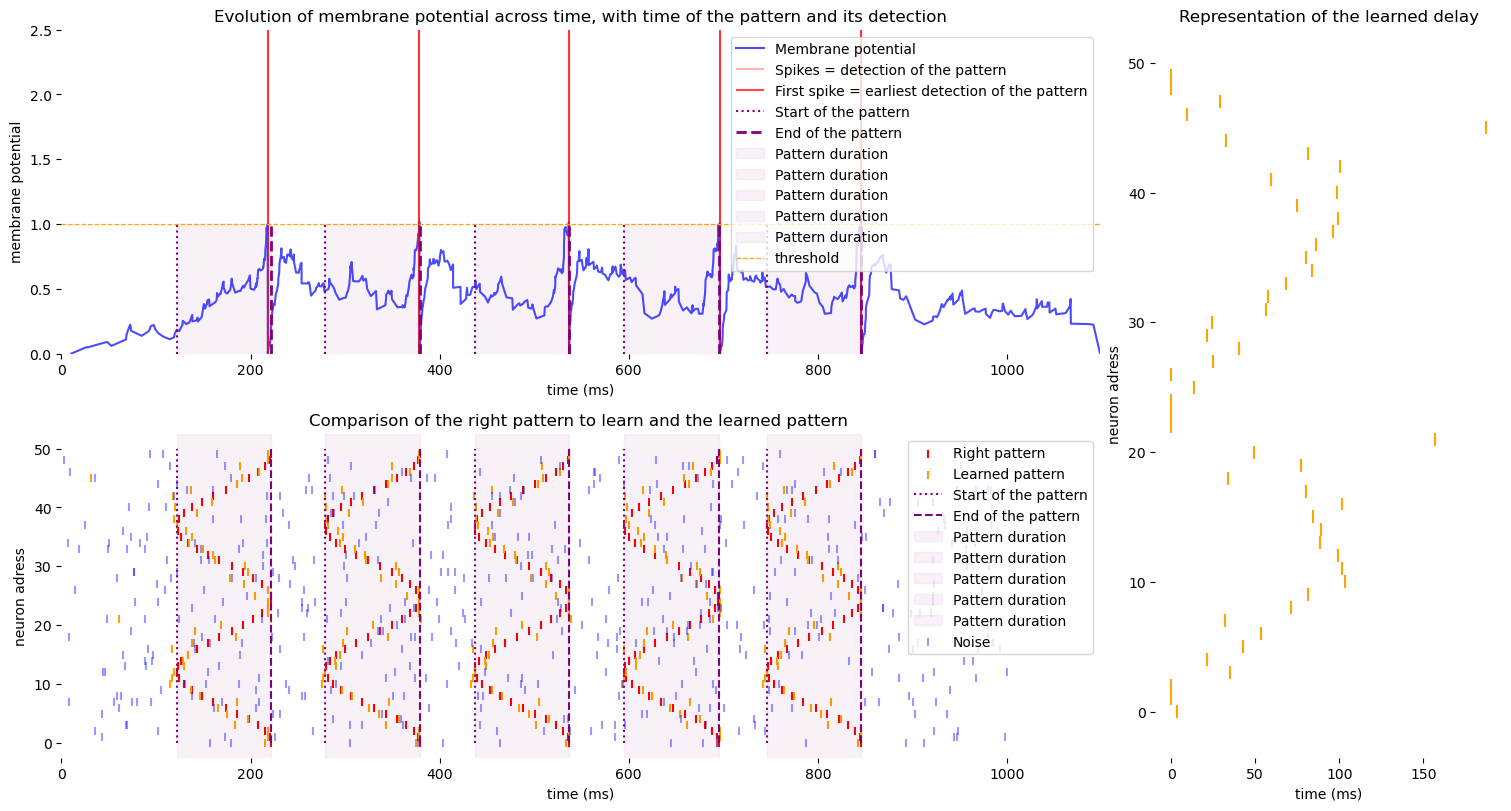

tau = 20 gain = 1.8400000000000047
epoch: 180
error: 0.0


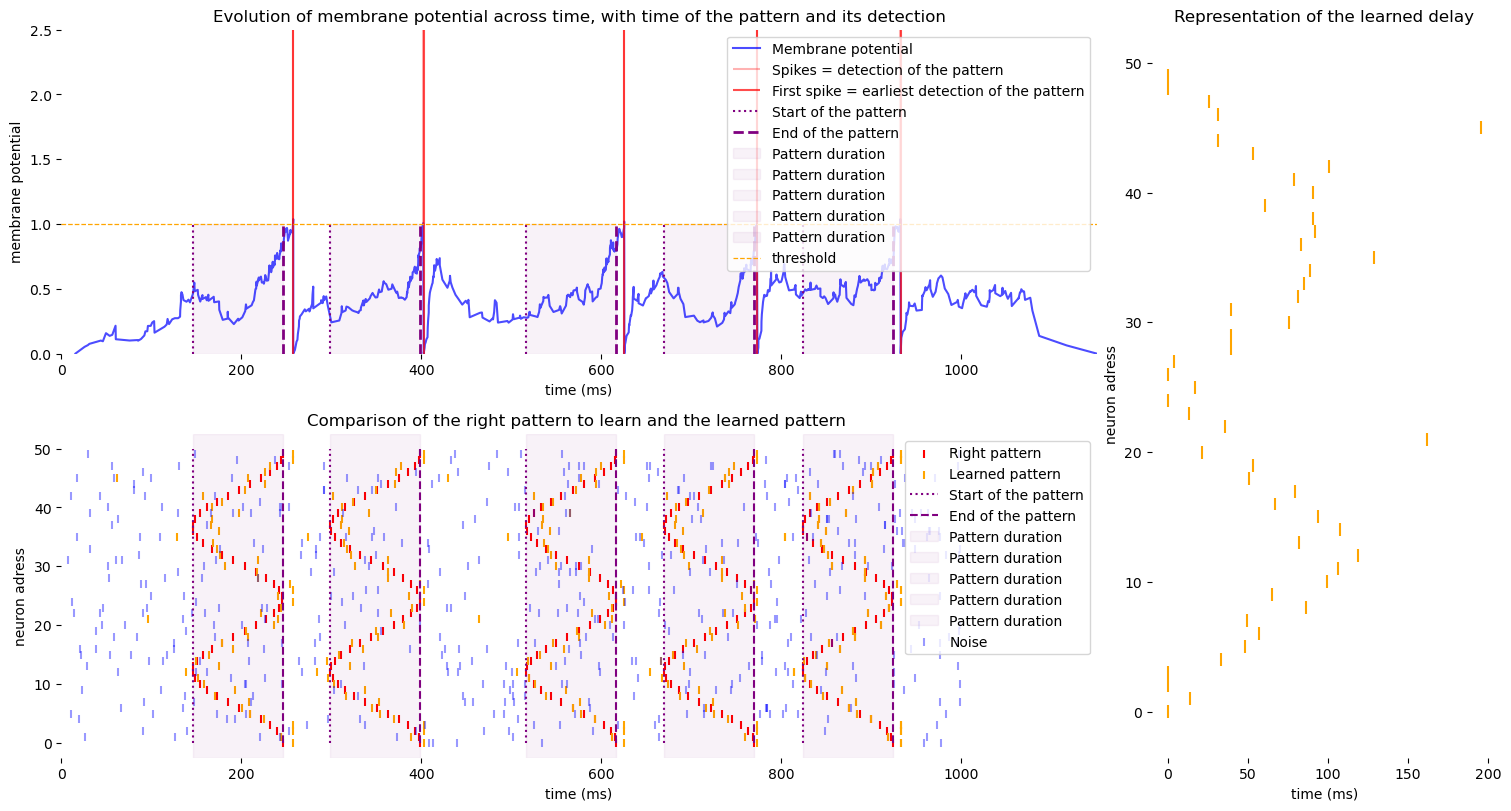

tau = 20 gain = 1.8100000000000047
epoch: 200
error: 0.19999999999999996


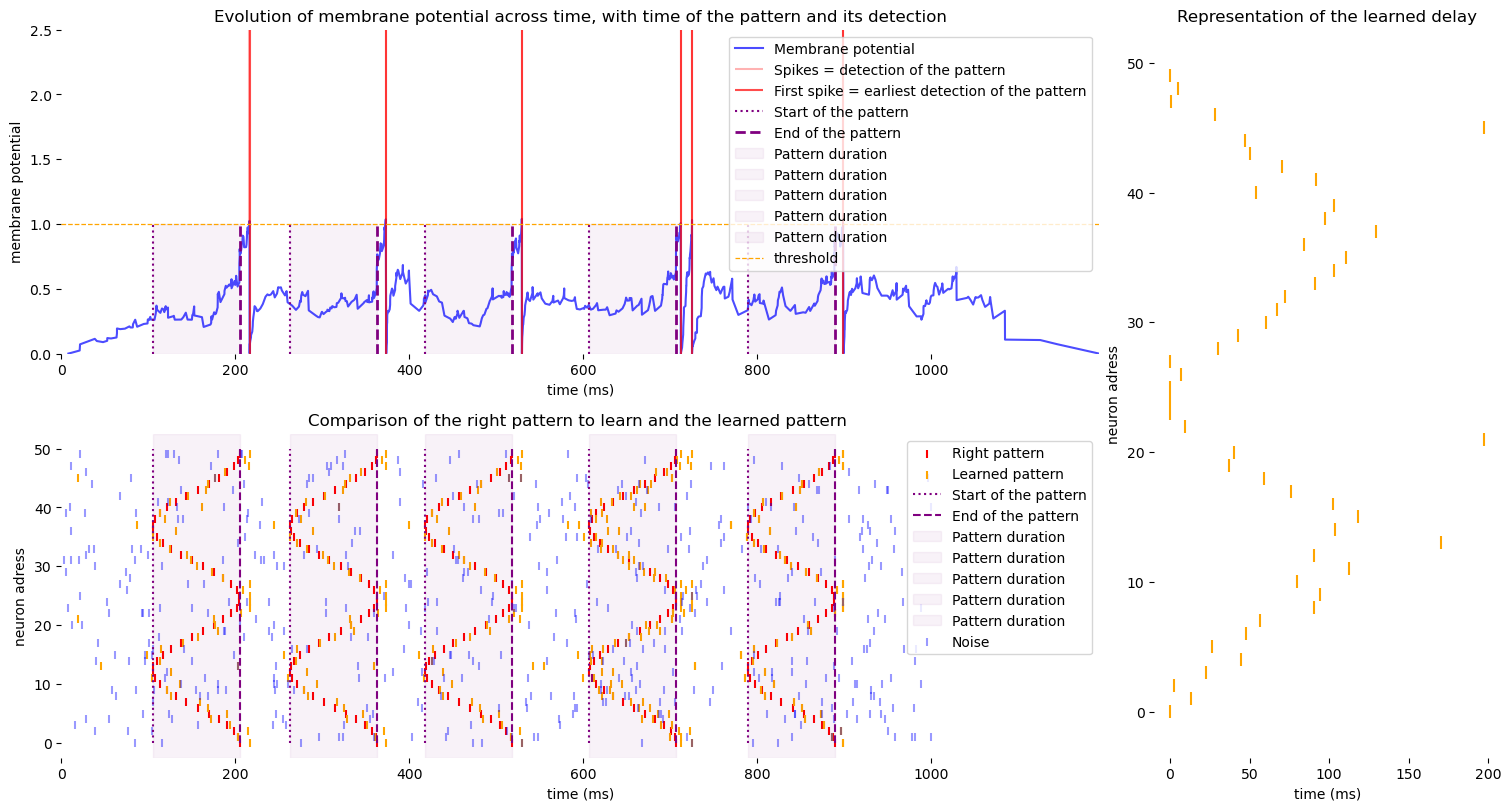

In [23]:
tau = 20 # delay_amplitude
gain = 3

N = hsd_neuron(nb_synapses, tau = tau, gain = gain, delay_amplitude = delay_amplitude)
# N.delays = saved_delays

noise_density =  10e-3
learning_rate_tau = 1
learning_rate_gain = 0.01
learning_rate_delay = 0.1
N_epochs = 201
lambda_delay = .0001
momentum = .3

nb_synapses, simulation_time, fs = 50, 1e3, 5
pattern_temporal_amplitude = delay_amplitude = 100
pattern = cospattern

delay_gradient_history = np.zeros((N_epochs, len(N.delays)))
delays_history = np.zeros((N_epochs, len(N.delays)))
error = np.zeros((N_epochs))

for i_epoch in range(N_epochs):
    t_true = poisson(fs,simulation_time,refractory=150,event_duration=100)[0]
#     t_true = t_true[t_true <simulation_time-delay_amplitude]
    
    aer_noise, aer_pattern, aer = make_spiketrains_motif(nb_synapses, noise_density, simulation_time, pattern_temporal_amplitude, t_true, function = pattern)
    V, sorted_times, sorted_addresses, t_out = N.code(aer)

    output_spikes_number = len(t_out) # number of times the pattern triggered a repsonse fro mthe Lif neuron
    expected_output_spikes = len(t_true)
    
    if output_spikes_number != expected_output_spikes: # if not enough spikes were triggered than tau (inverse decay) scales by the learning rate
#         N.tau += learning_rate_tau*expected_output_spikes
        N.gain += learning_rate_gain*(expected_output_spikes-(output_spikes_number))
    else:
        for t_post in t_out:
            V_out = V[sorted_times==t_post]
            delay_gradient = delay_gradient_ = np.zeros([len(N.delays)])
            miles_delay_gradients = np.zeros([len(N.delays)])
            for add in range(len(N.delays)):
                spike_times = sorted_times[np.where(sorted_addresses==add)[0]]
                if len(spike_times)>0:
#                     delta_delay = t_post-N.delays[add]-spike_times#[spike_times<t_post+delay_amplitude]
#                     delay_function = N.weights[add]*np.sign(delta_delay)*absolute_kernel(delta_delay, N.tau)*N.gain
#                     delay_gradient[add] = (delay_function).sum()
#                     #print(delay_gradient)
#                     delay_gradient[add] += lambda_delay*N.delays[add]
                    miles_delay_gradients[add] = np.sum([np.sum(STDP_weight(spike_times-(t_true_+delay_amplitude),tau)) for t_true_ in t_true])/len(t_true)
                    
                
            delay_gradient_ = momentum * delay_gradient_ + (1-momentum)*miles_delay_gradients
            N.delays += learning_rate_delay*delay_gradient_*delay_amplitude
            N.delays[N.delays<0]=0
            #if np.linalg.norm(N.delays)!=0:
            #    N.delays *= delay_amplitude/np.linalg.norm(N.delays)
            
            delay_gradient_history[i_epoch] = delay_gradient_
            delays_history[i_epoch] = N.delays
    
    error[i_epoch] = np.abs((1-output_spikes_number/expected_output_spikes))
    if i_epoch % (N_epochs//10) == 0:
        print('tau = ' + str(N.tau), 'gain = ' + str(N.gain))
        print('epoch: ' + str(i_epoch))
        print('error: ' + str(error[i_epoch]))
        plot_learning_figure(sorted_times, V, N, t_out, t_true, delay_amplitude, aer_noise, aer_pattern, delay_gradient=None)

In [1]:
plt.figure()
plt.plot(error)
plt.titles('error')
plt.show()

NameError: name 'plt' is not defined

# Unsupervised detection of spiking patterns??
what can I do with cross-correlograms...

In [1]:
from brainhack import *
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
nb_synapses, noise_density, simulation_time, fs = 50, .1e-3, 2e3, 6
pattern_temporal_amplitude = delay_amplitude = 100
pattern = cospattern


t_true = poisson(fs,simulation_time,refractory=100, event_duration=100)[0]
print(len(t_true))

aer_noise, aer_pattern, aer = make_spiketrains_motif(nb_synapses, noise_density, simulation_time, pattern_temporal_amplitude, t_true, function=pattern,discard_spikes=40)
# fig, ax = plot_input(time_pattern, aer_pattern)



12


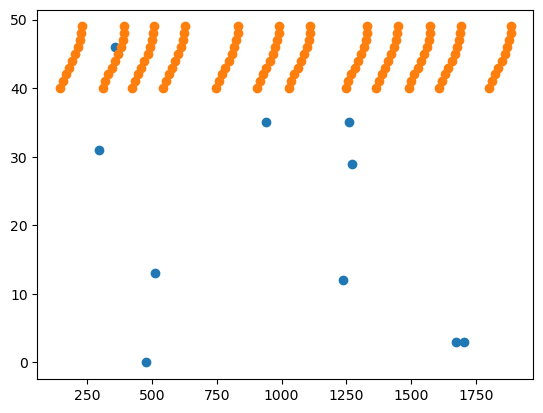

In [3]:
test = np.arange(0, simulation_time)
plt.figure()
plt.scatter(aer_noise[1], aer_noise[0])
plt.scatter(aer_pattern[1], aer_pattern[0])
# plt.scatter(all_timestamps,all_adresses)
# plt.scatter(aer[1], aer[0])
plt.show()

So first I want to generate some good fake data, lets try and make sure all of the firing rates are roughly equal? Before I can do that I need to clean up the data and sort it by neuron address isntead of scatter plot friendly form...

In [11]:
aer[0]
spiketrains = []
for sn in range(40,50):
    spiketrains.append(aer[1][np.where(aer[0] == sn)])


In [ ]:
trigger_neuron

that's better I think...

In [36]:
hists = np.zeros((10,10),dtype='object')
for trigger_neuron in range(len(spiketrains)):
    for other_neuron in range(len(spiketrains)):
        spike_triggered = np.array([])
        for trigger_spike in range(len(spiketrains[trigger_neuron])):
            temp = spiketrains[other_neuron]-spiketrains[trigger_neuron][trigger_spike]
        #     temp = temp[np.abs(temp) < 500]
            spike_triggered = np.hstack((spike_triggered, temp))
        hists[trigger_neuron][other_neuron] = spike_triggered


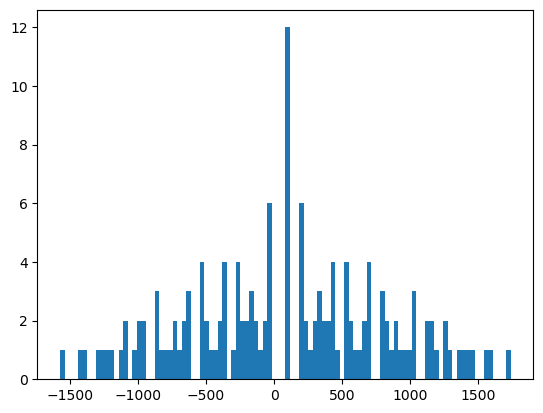

In [25]:
bins = 100
plt.figure()
x = plt.hist(hists[9],bins)
plt.show()

<Figure size 640x480 with 0 Axes>

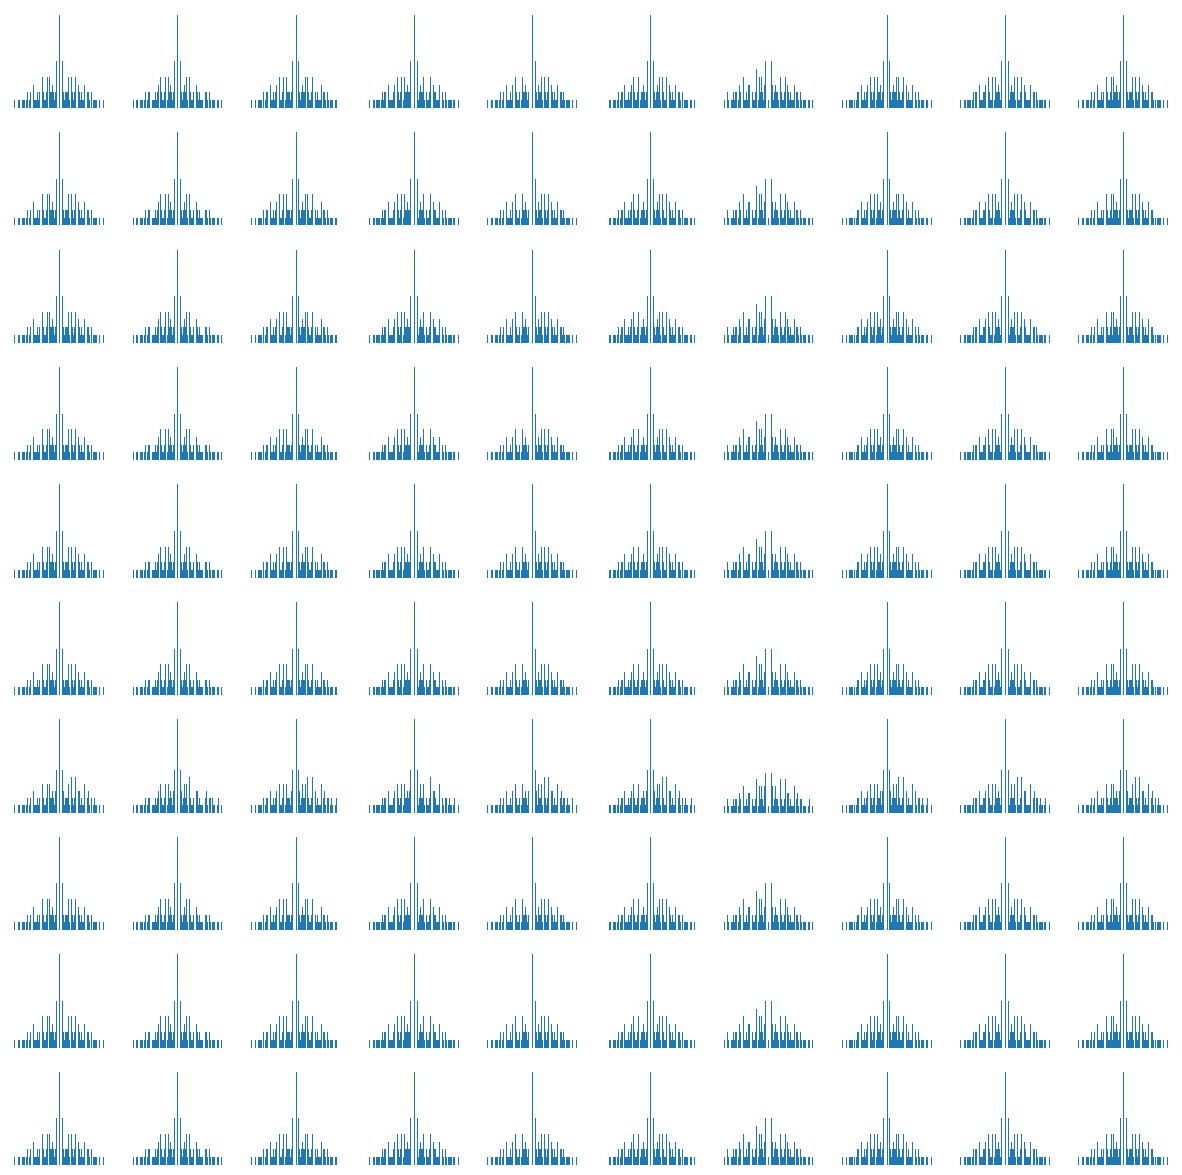

In [47]:
plt.figure()
fig, axs = plt.subplots(10, 10,  figsize=(15, 15))
for i in range(len(hists)):
    for j in range(len(hists)):
        axs[i][j].hist(hists[i][j],bins)
        axs[i][j].axis('off')
#     axs[i][i].set_xticks([])
#     axs[i][i].set_yticks([])
plt.show()


In [172]:
ind = np.argpartition(x[0], -len(t_true))[-len(t_true):]
occurrences = x[1][ind[np.argsort(x[0][ind])]]
occurrences

array([ -163.90367347,  -129.78367347,   654.97632653, -1051.02367347,
        -778.06367347,   825.57632653,  -607.46367347,   313.77632653,
        -470.98367347,   177.29632653,   518.49632653,    40.81632653])